# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 2 #1 #   #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_16895/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
71692  1694038800000   1632.06   1633.38  1632.05    1633.37    128.2817   
71693  1694039100000   1633.37   1633.70  1632.90    1632.91    273.8451   
71694  1694039400000   1632.91   1633.12  1632.64    1632.65    130.8252   
71695  1694039700000   1632.65   1633.12  1632.29    1632.94    272.5678   
71696  1694040000000   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00       1635.182500       1639.600000   
71693  2023-09-06 22:25:00       1634.597500       1639.600000   
71694  2023-09-06 22:30:00       1632.357500       1639.600000   
71695  2023-09-06 22:35:00       1631.175000       1639.600000   
71696  2023-09-06 22:40:00       1631.055000       1639.600000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
71692        1631.325  ...   NaN         NaN            NaN           NaN   
71693        1631.325  ...   NaN         NaN            NaN           NaN   
71694        1631.325  ...   NaN         NaN            NaN           NaN   
71695        1631.325  ...   NaN         NaN            NaN           NaN   
71696        1631.325  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
71692               NaN         0.0               NaN         0.0      0.0   
71693               NaN         0.0               NaN         0.0      0.0   
71694               NaN         0.0               NaN         0.0      0.0   
71695               NaN         0.0               NaN         0.0      0.0   
71696               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
71692   NaN  
71693   NaN  
71694   NaN  
71695   NaN  
71696   NaN  

[71697 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
71692  1694038800000   1632.06   1633.38  1632.05    1633.37    128.2817   
71693  1694039100000   1633.37   1633.70  1632.90    1632.91    273.8451   
71694  1694039400000   1632.91   1633.12  1632.64    1632.65    130.8252   
71695  1694039700000   1632.65   1633.12  1632.29    1632.94    272.5678   
71696  1694040000000   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00       1635.182500       1639.600000   
71693  2023-09-06 22:25:00       1634.597500       1639.600000   
71694  2023-09-06 22:30:00       1632.357500       1639.600000   
71695  2023-09-06 22:35:00       1631.175000       1639.600000   
71696  2023-09-06 22:40:00       1631.055000       1639.600000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
71692        1631.325  ...   NaN         NaN            NaN           NaN   
71693        1631.325  ...   NaN         NaN            NaN           NaN   
71694        1631.325  ...   NaN         NaN            NaN           NaN   
71695        1631.325  ...   NaN         NaN            NaN           NaN   
71696        1631.325  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
71692               NaN         0.0               NaN         0.0      0.0   
71693               NaN         0.0               NaN         0.0      0.0   
71694               NaN         0.0               NaN         0.0      0.0   
71695               NaN         0.0               NaN         0.0      0.0   
71696               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
71692                  NaN  
71693                  NaN  
71694                  NaN  
71695                  NaN  
71696                  NaN  

[71697 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       788
delta_event_real    788
delta_event_pred    788
Previous_num        788
Actual_num          788
Event               788
Date                788
Previous            788
Consensus           788
Actual              788
Country             788
Time (ET)           788
keep                788
date                788
dtype: int64

on 71697 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
71692   1632.06   1633.38  1632.05    1633.37    128.2817   
71693   1633.37   1633.70  1632.90    1632.91    273.8451   
71694   1632.91   1633.12  1632.64    1632.65    130.8252   
71695   1632.65   1633.12  1632.29    1632.94    272.5678   
71696   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00       1635.182500       1639.600000   
71693  2023-09-06 22:25:00       1634.597500       1639.600000   
71694  2023-09-06 22:30:00       1632.357500       1639.600000   
71695  2023-09-06 22:35:00       1631.175000       1639.600000   
71696  2023-09-06 22:40:00       1631.055000       1639.600000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710          1194.71  ...  1196.096667  1196.096667   
1            1194.710          1194.71  ...  1195.801420  1195.801420   
2            1194.710          1194.71  ...  1195.648641  1195.648641   
3            1194.710          1194.71  ...  1195.575250  1195.575250   
4            1194.710          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
71692        1631.325          1632.88  ...  1658.904295  1764.422097   
71693        1631.325          1633.38  ...  1658.899894  1764.412593   
71694        1631.325          1633.38  ...  1658.898270  1764.407735   
71695        1631.325          1633.38  ...  1658.894178  1764.398729   
71696        1631.325          1633.38  ...  1658.892653  1764.389146   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
71692  1814.849165  1704.676107   1729.996823         -0.564944 -0.059158   
71693  1814.847627  1704.649629   1729.996557         -0.567634 -0.059456   
71694  1814.847098  1704.643096   1729.996429         -0.569155 -0.059625   
71695  1814.845973  1704.628381   1729.996164         -0.567461 -0.059436   
71696  1814.845282  1704.619291   1729.996013         -0.565416 -0.059209   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.895196  
1      1.205254e+08      522461.0       17.895196  
2      1.205254e+08      522461.0       17.895196  
3      1.205254e+08      522461.0       17.895196  
4      1.205254e+08      522461.0       17.895196  
...             ...           ...             ...  
71692  1.202182e+08      453264.0       18.337742  
71693  1.202182e+08      453264.0       18.337742  
71694  1.202182e+08      453264.0       18.337742  
71695  1.202182e+08      453264.0       18.337742  
71696  1.202182e+08      453264.0       18.337742  

[71697 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
71692  4.438  4465.479980  104.833000
71693  4.438  4465.479980  104.833000
71694  4.438  4465.479980  104.833000
71695  4.438  4465.479980  104.833000
71696  4.438  4465.479980  104.833000

[71697 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

71697

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

57358

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
71692  1694038800000   1632.06   1633.38  1632.05    1633.37    128.2817   
71693  1694039100000   1633.37   1633.70  1632.90    1632.91    273.8451   
71694  1694039400000   1632.91   1633.12  1632.64    1632.65    130.8252   
71695  1694039700000   1632.65   1633.12  1632.29    1632.94    272.5678   
71696  1694040000000   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00       1635.182500       1639.600000   
71693  2023-09-06 22:25:00       1634.597500       1639.600000   
71694  2023-09-06 22:30:00       1632.357500       1639.600000   
71695  2023-09-06 22:35:00       1631.175000       1639.600000   
71696  2023-09-06 22:40:00       1631.055000       1639.600000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
71692        1631.325  ...         NaN            NaN           NaN   
71693        1631.325  ...         NaN            NaN           NaN   
71694        1631.325  ...         NaN            NaN           NaN   
71695        1631.325  ...         NaN            NaN           NaN   
71696        1631.325  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
71692               NaN         0.0               NaN         0.0      0.0   
71693               NaN         0.0               NaN         0.0      0.0   
71694               NaN         0.0               NaN         0.0      0.0   
71695               NaN         0.0               NaN         0.0      0.0   
71696               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
71692                  NaN  False  
71693                  NaN  False  
71694                  NaN  False  
71695                  NaN  False  
71696                  NaN  False  

[71697 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
57354  1689737400000   1911.86   1913.30  1910.63    1911.56    762.3453   
57355  1689737700000   1911.56   1912.80  1911.56    1912.79    231.6019   
57356  1689738000000   1912.79   1912.80  1909.80    1911.15    538.4433   
57357  1689738300000   1911.15   1912.59  1910.84    1912.54    404.7651   
57358  1689738600000   1912.54   1912.59  1911.35    1912.58    347.4221   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
57354  2023-07-19 03:30:00       1905.792500       1903.035000   
57355  2023-07-19 03:35:00       1905.887500       1903.055000   
57356  2023-07-19 03:40:00       1906.075000       1903.100000   
57357  2023-07-19 03:45:00       1906.007500       1903.100000   
57358  2023-07-19 03:50:00       1906.007500       1903.100000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
57354        1910.005  ...         4.7            4.8           4.8   
57355        1910.005  ...         4.7            4.8           4.8   
57356        1910.005  ...         4.7            4.8           4.8   
57357        1910.620  ...         4.7            4.8           4.8   
57358        1910.620  ...         4.7            4.8           4.8   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
57354               0.0         0.0               0.1         0.0      0.0   
57355               0.0         0.0               0.1         0.0      0.0   
57356               0.0         0.0               0.1         0.0      0.0   
57357               0.0         0.0               0.1         0.0      0.0   
57358               0.0         0.0               0.1         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
57354  2023-08-10 13:00:00   True  
57355  2023-08-10 13:00:00   True  
57356  2023-08-10 13:00:00   True  
57357  2023-08-10 13:00:00   True  
57358  2023-08-10 13:00:00   True  

[57359 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
57359  1689738900000   1912.59   1913.33  1911.82    1912.48    703.3901   
57360  1689739200000   1912.48   1913.88  1912.21    1913.63    972.2586   
57361  1689739500000   1913.63   1915.25  1913.63    1915.13    347.7686   
57362  1689739800000   1915.13   1915.13  1912.96    1913.54    750.3720   
57363  1689740100000   1913.54   1917.18  1913.41    1916.60   1269.8810   
...              ...       ...       ...      ...        ...         ...   
71692  1694038800000   1632.06   1633.38  1632.05    1633.37    128.2817   
71693  1694039100000   1633.37   1633.70  1632.90    1632.91    273.8451   
71694  1694039400000   1632.91   1633.12  1632.64    1632.65    130.8252   
71695  1694039700000   1632.65   1633.12  1632.29    1632.94    272.5678   
71696  1694040000000   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
57359  2023-07-19 03:55:00         1906.0075            1903.1   
57360  2023-07-19 04:00:00         1905.6900            1903.1   
57361  2023-07-19 04:05:00         1906.1375            1903.1   
57362  2023-07-19 04:10:00         1905.9050            1903.1   
57363  2023-07-19 04:15:00         1905.9050            1903.1   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00         1635.1825            1639.6   
71693  2023-09-06 22:25:00         1634.5975            1639.6   
71694  2023-09-06 22:30:00         1632.3575            1639.6   
71695  2023-09-06 22:35:00         1631.1750            1639.6   
71696  2023-09-06 22:40:00         1631.0550            1639.6   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
57359        1911.160  ...         4.7            4.8           4.8   
57360        1911.160  ...         4.7            4.8           4.8   
57361        1911.160  ...         4.7            4.8           4.8   
57362        1911.160  ...         4.7            4.8           4.8   
57363        1912.030  ...         4.7            4.8           4.8   
...               ...  ...         ...            ...           ...   
71692        1631.325  ...         NaN            NaN           NaN   
71693        1631.325  ...         NaN            NaN           NaN   
71694        1631.325  ...         NaN            NaN           NaN   
71695        1631.325  ...         NaN            NaN           NaN   
71696        1631.325  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
57359               0.0         0.0               0.1         0.0      0.0   
57360               0.0         0.0               0.1         0.0      0.0   
57361               0.0         0.0               0.1         0.0      0.0   
57362               0.0         0.0               0.1         0.0      0.0   
57363               0.0         0.0               0.1         0.0      0.0   
...                 ...         ...               ...         ...      ...   
71692               NaN         0.0               NaN         0.0      0.0   
71693               NaN         0.0               NaN         0.0      0.0   
71694               NaN         0.0               NaN         0.0      0.0   
71695               NaN         0.0               NaN         0.0      0.0   
71696               NaN         0.0               NaN         0.0      0.0   

                      date  train  
57359  2023-08-10 13:00:00  False  
57360  2023-08-10 13:00:00  False  
57361  2023-08-10 13:00:00  False  
57362  2023-08-10 13:00:00  False  
57363  2023-08-10 13:00:00  False  
...                    ...    ...  
71692                  NaN  False  
71693                  NaN  False  
71694                  NaN  False  
71695                  NaN  False  
71696                  NaN  False  

[14338 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(57272, 72, 102) (57272, 15)
(14251, 72, 102) (14251, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00023573, 1.00018858, 1.00038241, 1.00145629, 1.00074386,
       1.00115246, 1.00210062, 1.00264018, 1.00180203, 1.00254589,
       1.00152439, 1.001362  , 1.00200633, 1.00114722, 1.00187537])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99829855, 0.99938748, 0.99962306, ..., 1.00091093, 1.00074864,
        1.00139258],
       [1.00109079, 1.00132677, 1.00127958, ..., 1.00245427, 1.0030993 ,
        1.00223926],
       [1.00023573, 1.00018858, 1.00038241, ..., 1.00200633, 1.00114722,
        1.00187537]])

In [39]:
seq_y

array([1.00023573, 1.00018858, 1.00038241, 1.00145629, 1.00074386,
       1.00115246, 1.00210062, 1.00264018, 1.00180203, 1.00254589,
       1.00152439, 1.001362  , 1.00200633, 1.00114722, 1.00187537])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99829855, 0.99938748, 0.99962306, ..., 1.00091093, 1.00074864,
        1.00139258],
       [1.00109079, 1.00132677, 1.00127958, ..., 1.00245427, 1.0030993 ,
        1.00223926],
       [1.00023573, 1.00018858, 1.00038241, ..., 1.00200633, 1.00114722,
        1.00187537]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(57272, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(57272, 72, 102) (57272, 15)
(14251, 72, 102) (14251, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99829855, 0.99938748, 0.99962306, ..., 1.00091093, 1.00074864,
        1.00139258],
       [1.00109079, 1.00132677, 1.00127958, ..., 1.00245427, 1.0030993 ,
        1.00223926],
       [1.00023573, 1.00018858, 1.00038241, ..., 1.00200633, 1.00114722,
        1.00187537]])

In [47]:
np.mean(y_train_sca)

3.2098731217345215e-05

In [48]:
np.std(y_train_sca)

0.9999295439403669

In [49]:
np.mean(y_test_sca)

-0.03664534368327783

In [50]:
np.std(y_test_sca)

0.7108134240249901

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1746.178516       1745.691288   
1    1195.38   1196.31   1196.69  1194.90       1746.178516       1745.691288   
2    1194.55   1195.38   1195.81  1194.55       1746.178516       1745.691288   
3    1195.98   1194.55   1195.98  1194.31       1746.178516       1745.691288   
4    1196.06   1195.98   1196.37  1195.97       1746.178516       1745.691288   
5    1196.61   1196.06   1196.70  1196.06       1746.178516       1745.691288   
6    1194.36   1196.62   1196.62  1193.72       1746.178516       1745.691288   
7    1194.22   1194.37   1194.43  1192.72       1746.178516       1745.691288   
8    1193.64   1194.22   1194.22  1193.02       1746.178516       1745.691288   
9    1194.64   1193.64   1195.06  1193.63       1746.178516       1745.691288   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1749.111628   
1         1194.71          1194.71           1749.111628   
2         1194.71          1194.71           1749.111628   
3         1194.71          1194.71           1749.111628   
4         1194.71          1194.71           1749.111628   
5         1194.71          1194.71           1749.111628   
6         1194.71          1194.71           1749.111628   
7         1194.71          1194.71           1749.111628   
8         1194.71          1194.71           1749.111628   
9         1194.71          1194.71           1749.111628   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
1           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
2           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
3           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
4           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
5           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
6           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
7           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
8           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   
9           1741.409299  ...  1.205254e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1912.48 1913.63 1915.13 1913.54 1916.6  1916.54 1915.36 1917.88 1916.21
 1914.18]
X_test_raw     :  [1912.48 1913.63 1915.13 1913.54 1916.6  1916.54 1915.36 1917.88 1916.21
 1914.18]


## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(4123584, 102)

In [57]:
X_train[:,-1,:].shape

(57272, 102)

In [58]:
X_test[:,-1,:].shape

(14251, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.026939  0.003862 -0.055163  0.099195         -0.020144   
1       0.026939 -0.021360 -0.066072  0.073876         -0.049670   
2       0.026939  0.036315 -0.046081  0.106442         -0.043926   
3       0.026939  0.110278  0.016682  0.112767          0.017887   
4       0.026939 -0.044802 -0.064255  0.051247         -0.019646   
...          ...       ...       ...       ...               ...   
71518   0.026939 -0.100165 -0.066315 -0.077925          0.408458   
71519   0.026939  0.059674 -0.034341  0.069912          0.331852   
71520   0.026939 -0.062471 -0.066981  0.033511          0.213769   
71521   0.026939  0.049750 -0.041019  0.113027          0.224105   
71522   0.026939 -0.016255 -0.062323  0.060030          0.197706   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.037884       -0.112771        -0.018750   
1              0.004466       -0.141040        -0.048476   
2              0.009932       -0.127939        -0.017395   
3              0.065248       -0.051018         0.063450   
4              0.016614       -0.118647        -0.007629   
...                 ...             ...              ...   
71518          0.455685        0.001073        -0.009724   
71519          0.477189        0.030831         0.021514   
71520          0.416294       -0.053438        -0.066948   
71521          0.431508       -0.032384        -0.044846   
71522          0.401534       -0.026464        -0.088390   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  7.612295              7.164283  ...  0.367134  1.365844   
1                  7.601277              7.153884  ...  0.001030  1.414021   
2                  7.603079              7.155585  ...  0.001030  1.414021   
3                  7.621316              7.172797  ...  0.001030  1.414021   
4                  7.605282              7.157664  ...  0.001030  1.414021   
...                     ...                   ...  ...       ...       ...   
71518              0.039394              0.401617  ...  1.001246 -0.999672   
71519              0.044213              0.406278  ...  1.001246 -0.999672   
71520              0.030566              0.393077  ...  1.001246 -0.999672   
71521              0.033976              0.396376  ...  1.001246 -0.999672   
71522              0.027258              0.389878  ...  1.001246 -0.999672   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.865422    -1.107748          1.403927          0.222283 -0.059202   
1         0.865422    -1.107748          1.403927          0.222283 -0.059202   
2         0.865422    -1.107748          1.403927          0.222283 -0.059202   
3         0.865422    -1.107748          1.403927          0.222283 -0.059202   
4         0.865422    -1.107748          1.403927          0.222283 -0.059202   
...            ...          ...               ...               ...       ...   
71518    -0.329400     1.380345          0.459401          1.289319 -0.059202   
71519    -0.329400     1.380345          0.459401          1.289319 -0.059202   
71520    -0.329400     1.380345          0.459401          1.289319 -0.059202   
71521    -0.329400     1.380345          0.459401          1.289319 -0.059202   
71522    -0.329400     1.380345          0.459401          1.289319 -0.059202   

       event_pred  event_real  TRAIN  
0       -0.001079   -0.002413    1.0  
1       -0.001079   -0.002413    1.0  
2       -0.001079   -0.002413    1.0  
3       -0.001079   -0.002413    1.0  
4       -0.001079   -0.002413    1.0  
...           ...         ...    ...  
71518   -0.001079   -0.002413    0.0  
71519   -0.001079   -0.002413    0.0  
71520   -0.001079   -0.002413    0.0  
71521   -0.001079   -0.002413    0.0  
71522   -0.001079   -0.002413    0.0  

[71523 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  5.727200e+04  57272.000000  57272.000000  57272.000000   
mean   2.693912e-02      0.026553      0.026849      0.026594   
std    3.075345e-14      0.166295      0.126834      0.130063   
min    2.693912e-02     -5.191527     -0.066981     -5.134226   
25%    2.693912e-02     -0.038549     -0.046910     -0.002606   
50%    2.693912e-02      0.026750     -0.008417      0.063338   
75%    2.693912e-02      0.090701      0.055339      0.102644   
max    2.693912e-02      3.361799      3.295827      0.123632   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      57272.000000      57272.000000    57272.000000     57272.000000   
mean           0.015504          0.014751        0.024744         0.026136   
std            0.628126          0.680708        0.360963         0.231397   
min           -5.282154         -5.468437       -3.622180        -3.572713   
25%           -0.203882         -0.227550       -0.128995        -0.073460   
50%            0.027594          0.030573        0.035720         0.030716   
75%            0.250339          0.290839        0.191829         0.133236   
max            6.447064          5.927947        3.772896         3.292735   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          57272.000000          57272.000000  ...  57272.000000   
mean              -0.000350             -0.000177  ...      0.000495   
std                0.973217              0.976906  ...      1.000339   
min               -3.045519             -2.604537  ...     -1.413490   
25%               -0.410246             -0.458368  ...     -0.999187   
50%               -0.032663             -0.042365  ...      0.001030   
75%                0.315177              0.377211  ...      1.001246   
max                7.636769              7.187382  ...      1.415549   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  57272.000000  57272.000000  57272.000000      57272.000000   
mean      -0.000677     -0.000437      0.001678         -0.001730   
std        0.999679      0.999835      1.000188          0.999796   
min       -1.413796     -1.287573     -1.381230         -1.384562   
25%       -0.999672     -1.287573     -1.107748         -1.044734   
50%        0.000113     -0.329400     -0.000442         -0.047247   
75%        0.999897      0.865422      1.106863          0.994622   
max        1.414021      1.397167      1.380345          1.432763   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      57272.000000  57272.000000  5.727200e+04  5.727200e+04  57272.0  
mean          -0.000838     -0.000009 -1.695578e-07 -3.791436e-07      1.0  
std            1.000235      0.999930  9.999302e-01  9.999302e-01      0.0  
min           -1.487373     -0.059202 -6.178731e+01 -6.908167e+01      1.0  
25%           -0.991216     -0.059202 -1.078990e-03 -2.412701e-03      1.0  
50%            0.079781     -0.059202 -1.078990e-03 -2.412701e-03      1.0  
75%            0.993425     -0.059202 -1.078990e-03 -2.412701e-03      1.0  
max            1.358974     16.891270  6.178515e+01  6.907685e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.425100e+04  14251.000000  14251.000000  14251.000000   
mean   2.693912e-02      0.028575     -0.016161      0.073205   
std    4.517378e-15      0.134905      0.118333      0.088917   
min    2.693912e-02     -3.330055     -0.066981     -3.301602   
25%    2.693912e-02     -0.009150     -0.063029      0.058212   
50%    2.693912e-02      0.027877     -0.040005      0.096832   
75%    2.693912e-02      0.065670     -0.001199      0.119742   
max    2.693912e-02     10.157820     10.362712      0.123632   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      14251.000000      14251.000000    14251.000000     14251.000000   
mean           0.068216          0.084146        0.055064         0.039540   
std            0.403708          0.436399        0.245101         0.155908   
min           -3.775443         -3.590795       -4.277856        -2.809013   
25%           -0.068327         -0.065259       -0.039321        -0.024971   
50%            0.055259          0.070982        0.055695         0.039409   
75%            0.189555          0.225102        0.151061         0.102045   
max            8.880087          9.124083        6.000768         5.605660   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          14251.000000          14251.000000  ...  14251.000000   
mean               0.152610              0.243197  ...     -0.005157   
std                0.377716              0.370416  ...      1.000232   
min               -0.798476             -0.586020  ...     -1.413490   
25%                0.001055              0.004635  ...     -0.999187   
50%                0.091109              0.202010  ...      0.001030   
75%                0.218774              0.386159  ...      1.001246   
max                3.031135              2.950454  ...      1.415549   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  14251.000000  14251.000000  14251.000000      14251.000000   
mean      -0.006492     -0.018199      0.013026          0.245575   
std        0.999798      0.994280      1.005809          0.957387   
min       -1.413796     -1.287573     -1.381230         -1.377335   
25%       -0.999672     -1.287573     -1.107748         -0.596266   
50%        0.000113     -0.329400     -0.000442          0.513336   
75%        0.999897      0.865422      1.106863          1.180279   
max        1.414021      1.397167      1.380345          1.432763   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      14251.000000  14251.000000  14251.000000  14251.000000  14251.0  
mean          -0.209332     -0.029467     -0.005415     -0.002413      0.0  
std            1.009386      0.709354      0.517570      0.818380      0.0  
min           -1.485547     -0.059202    -61.787305    -69.081675      0.0  
25%           -1.189611     -0.059202     -0.001079     -0.002413      0.0  
50%           -0.350682     -0.059202     -0.001079     -0.002413      0.0  
75%            0.772321     -0.059202     -0.001079     -0.002413      0.0  
max            1.357148     16.891270     -0.001079     69.076849      0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

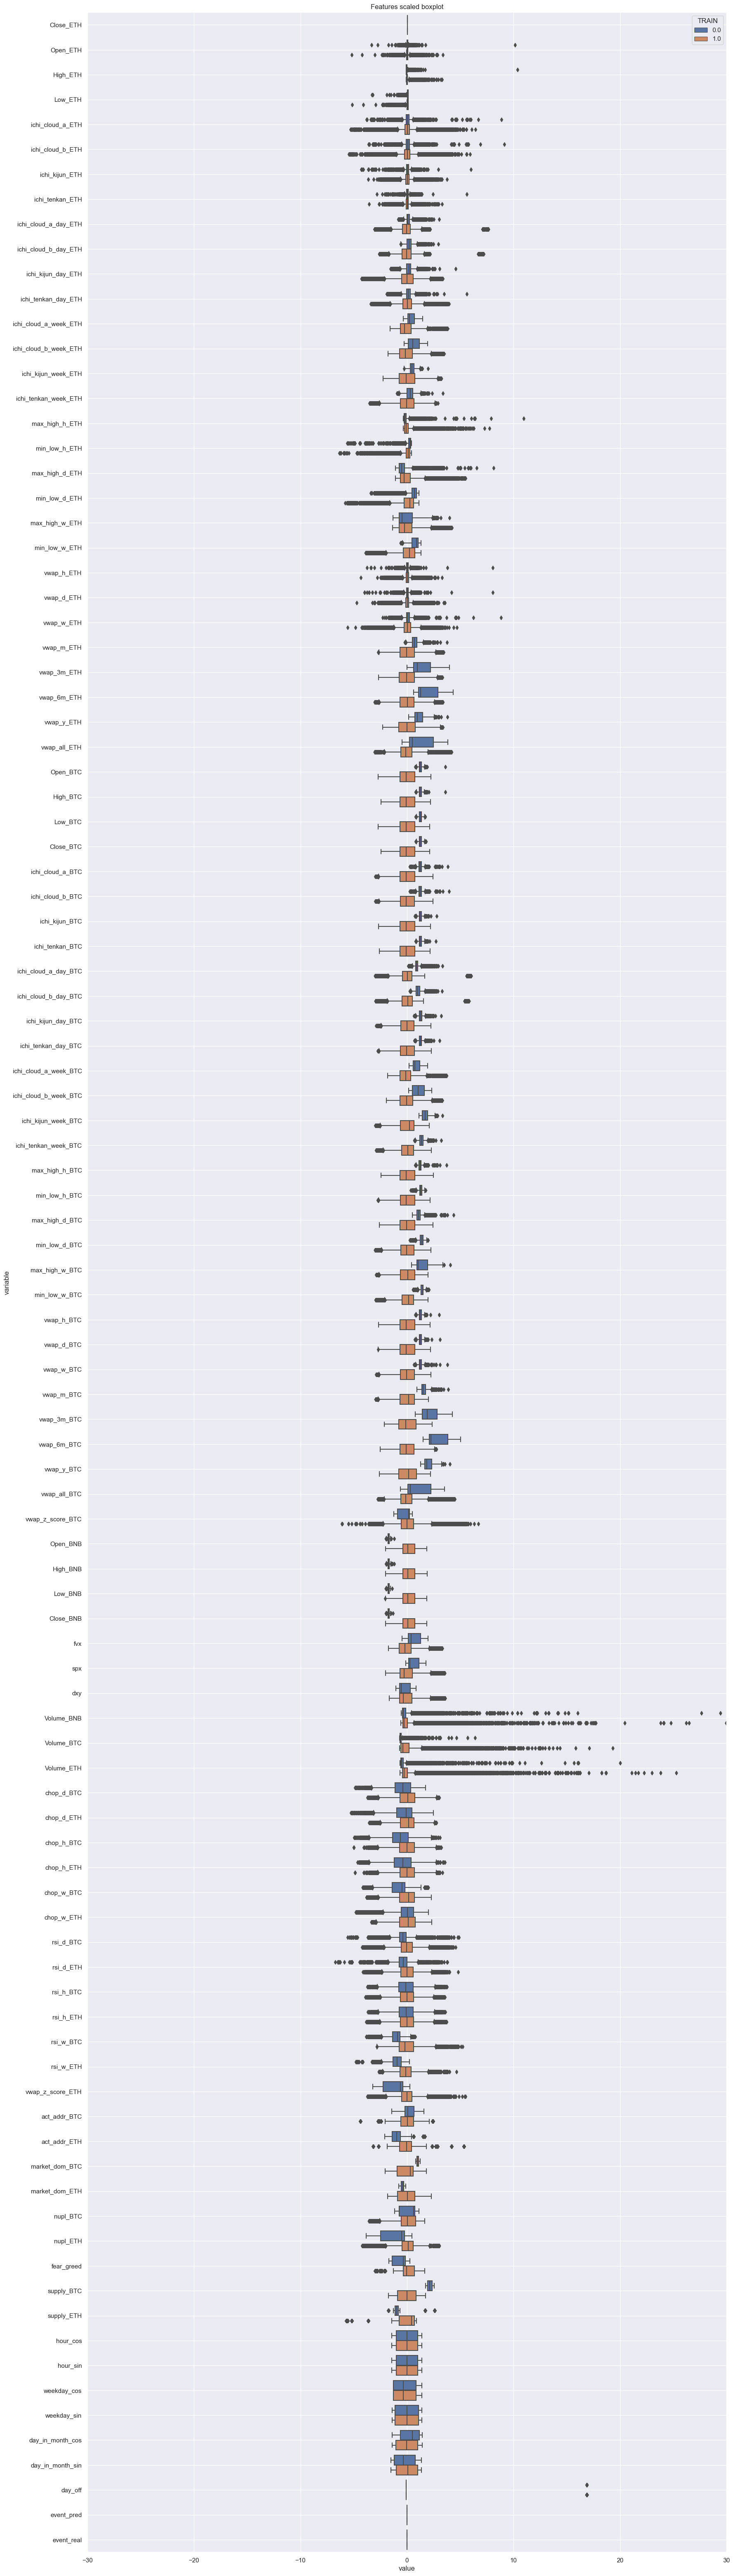

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

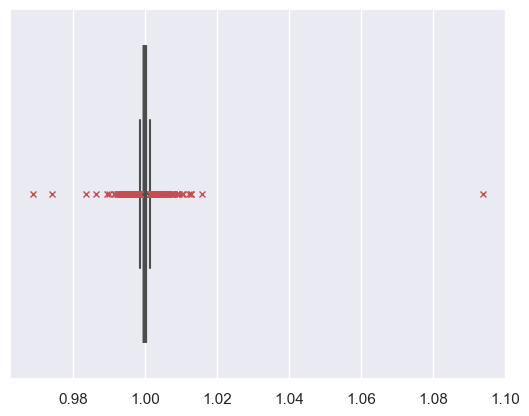

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


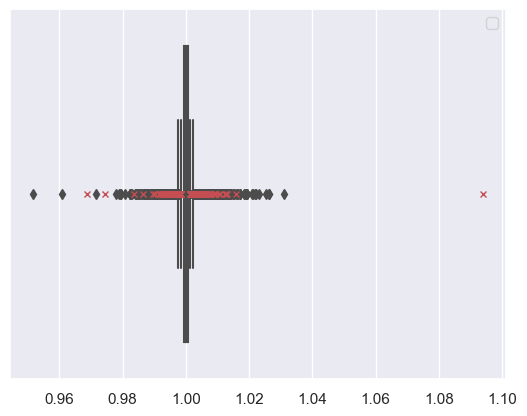

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

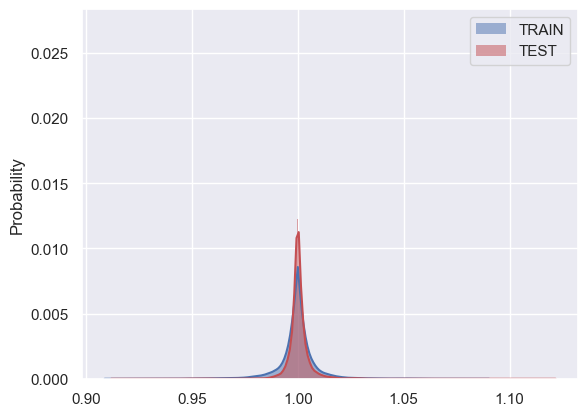

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(57272, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(57272, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08941708],
       [-0.034806  ],
       [-0.19391717],
       ...,
       [-0.41186634],
       [ 0.23558057],
       [ 0.0373156 ]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(57272, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

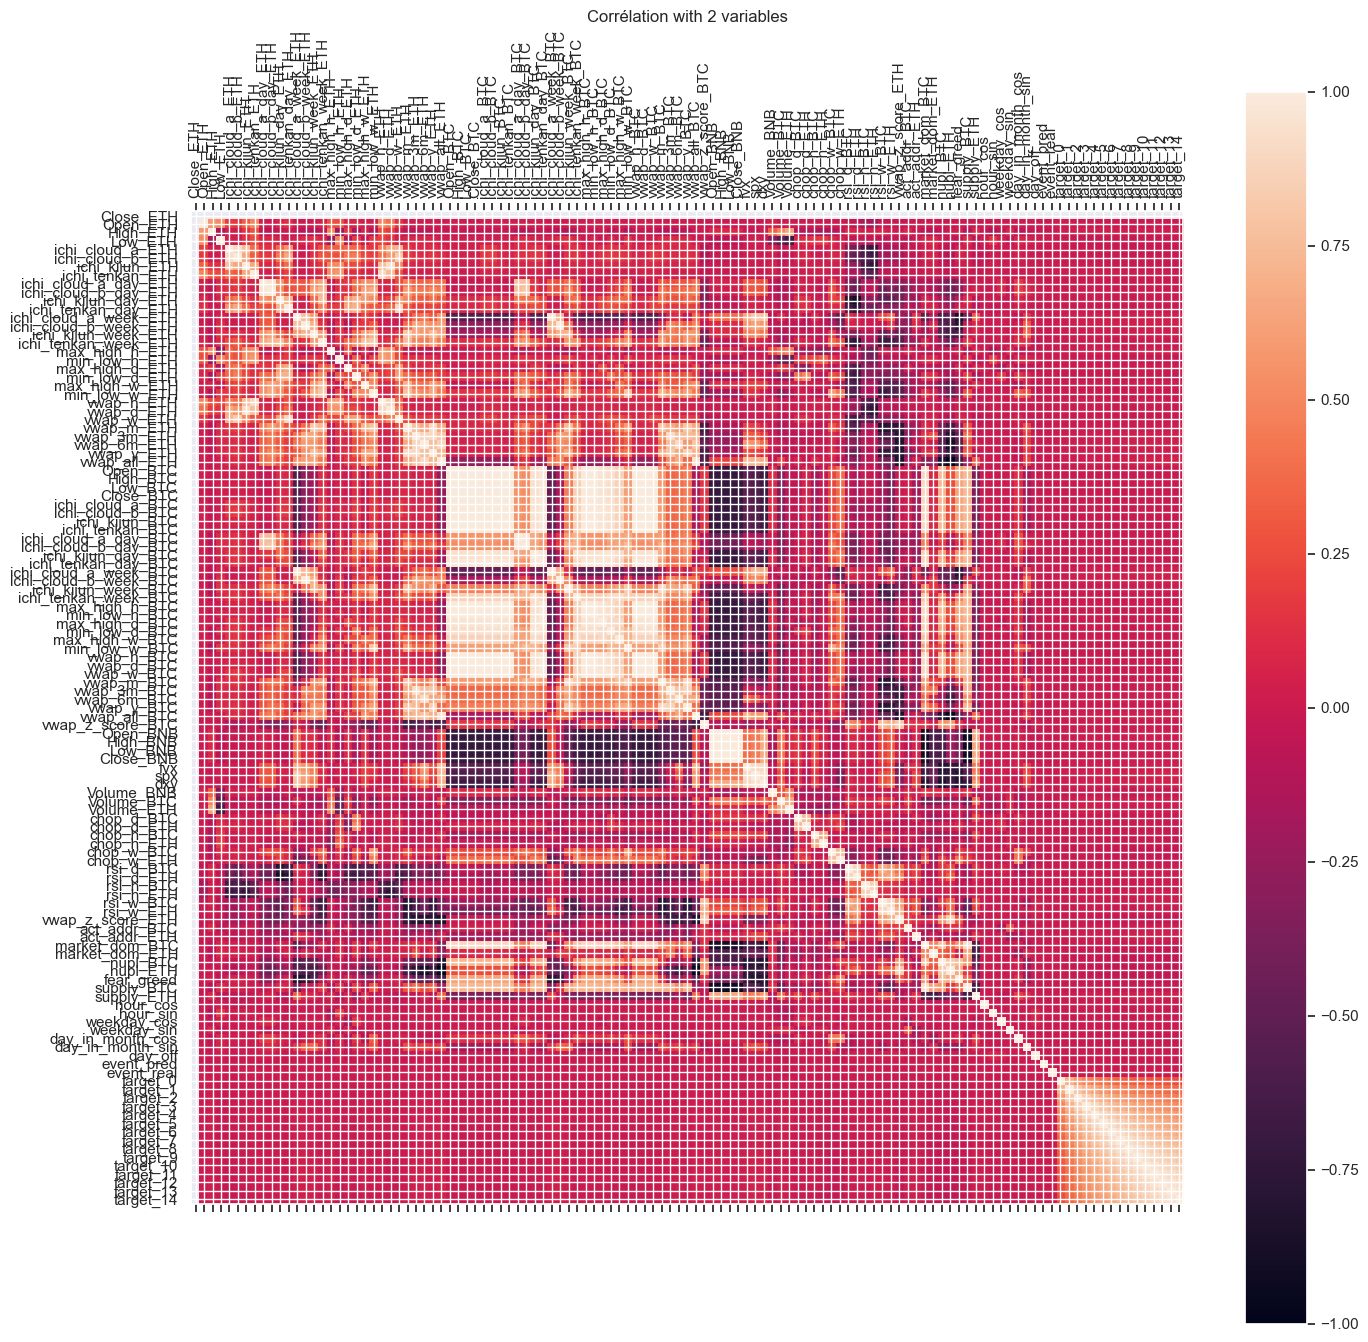

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


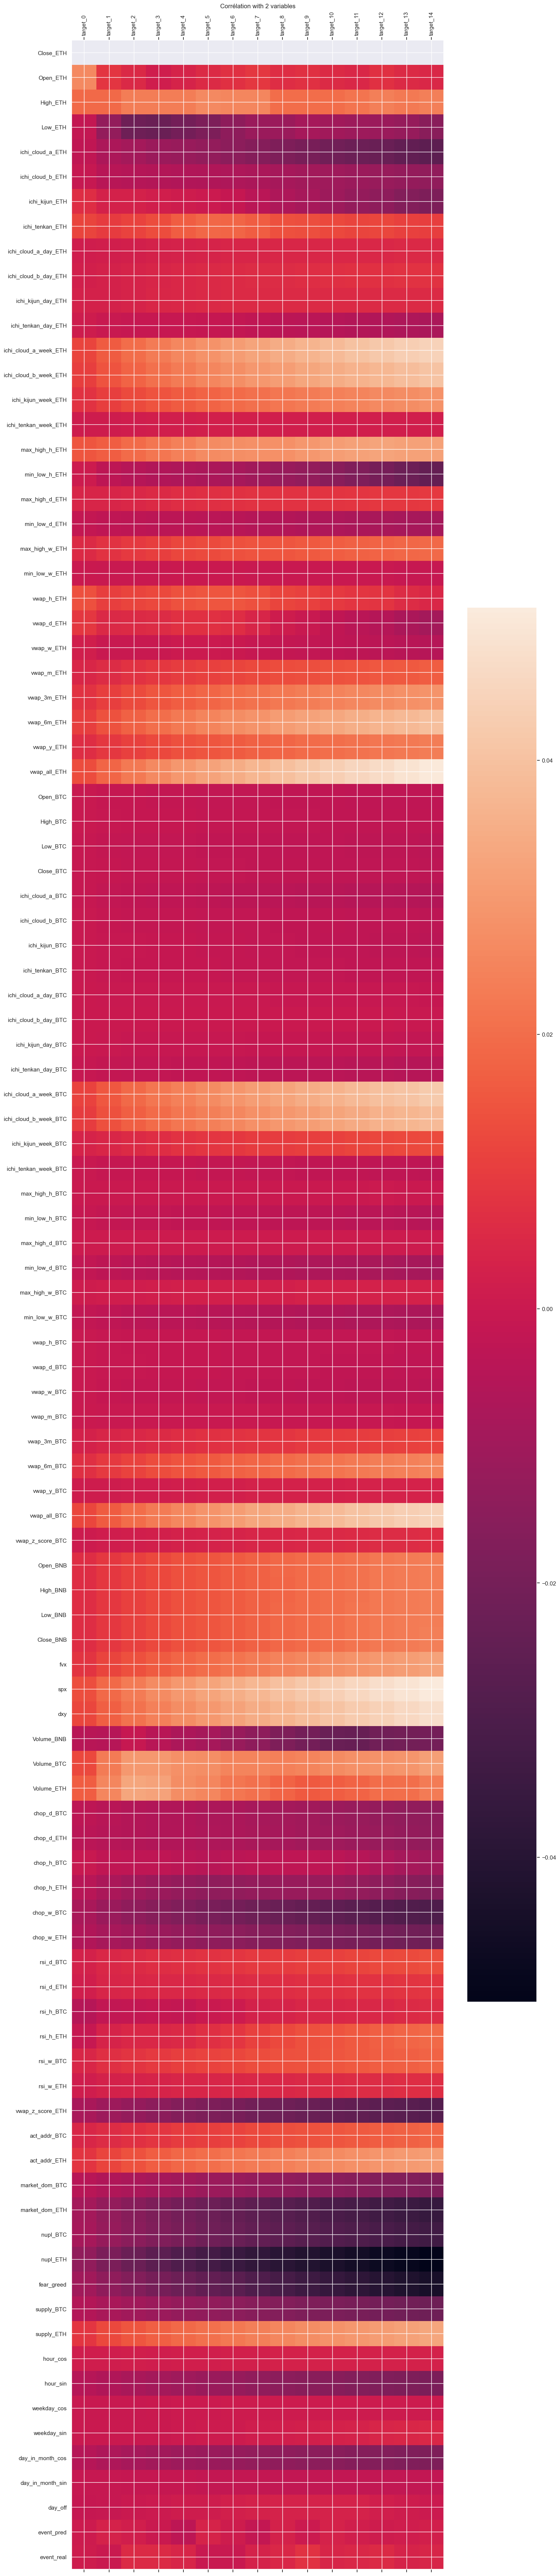

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


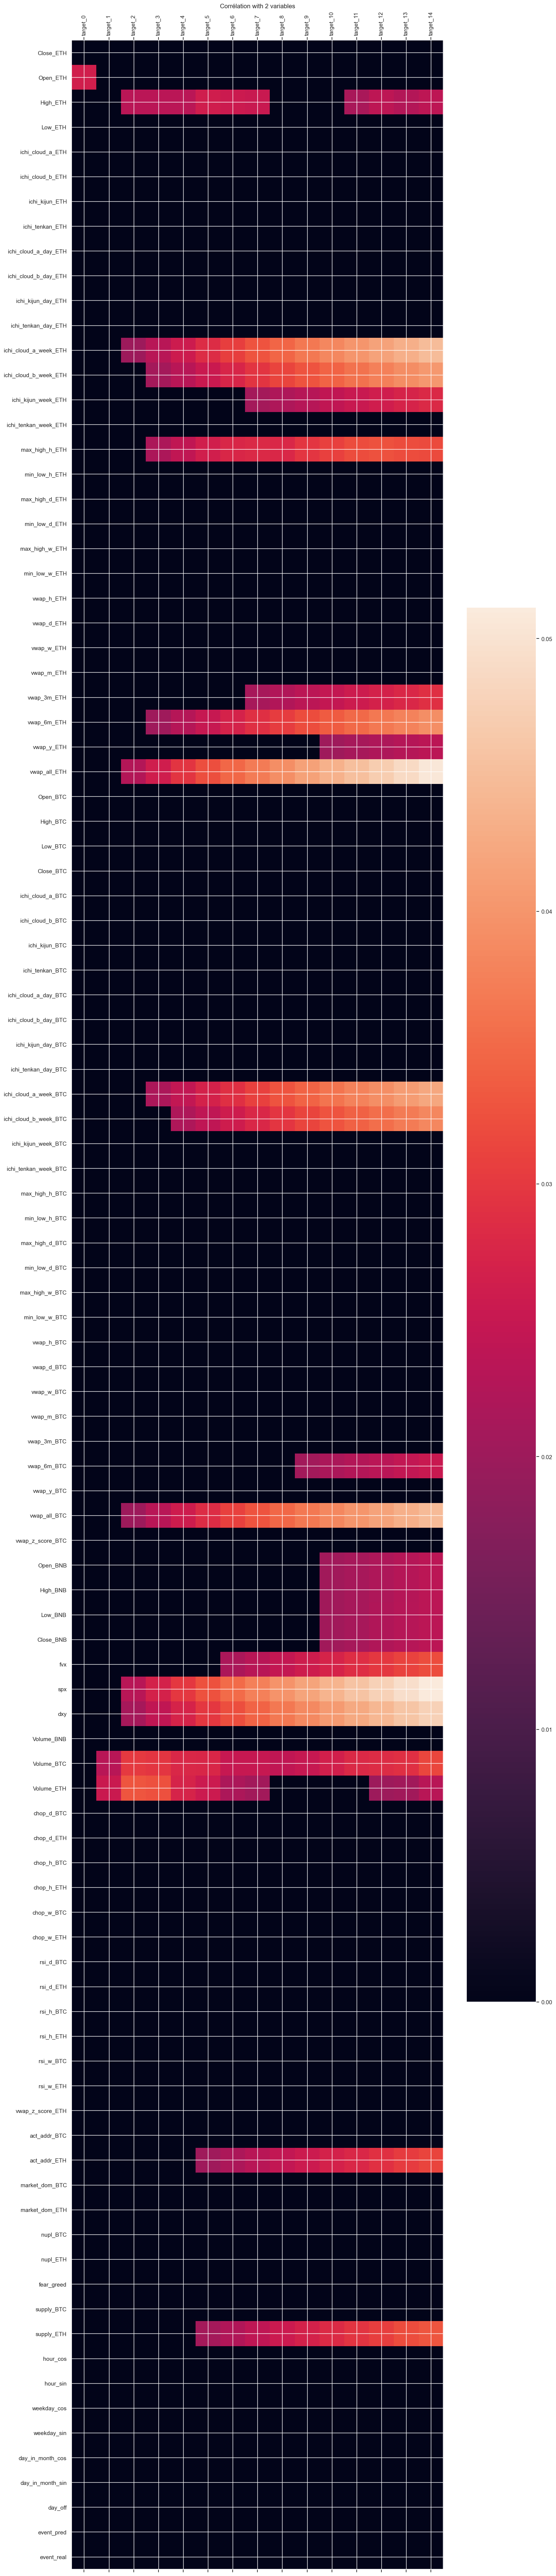

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

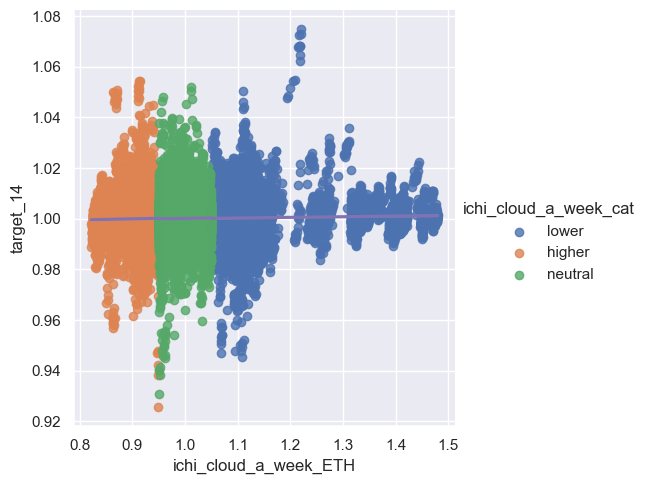

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

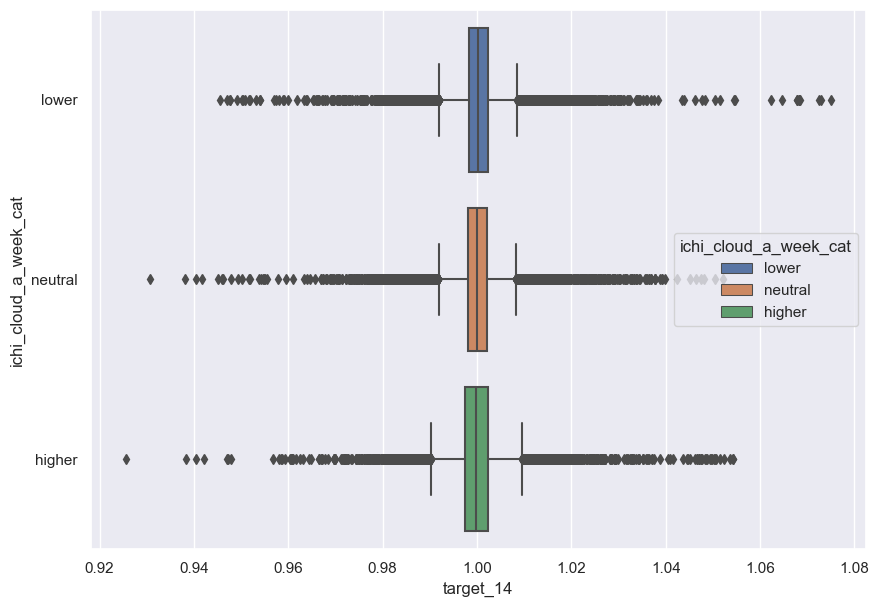

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


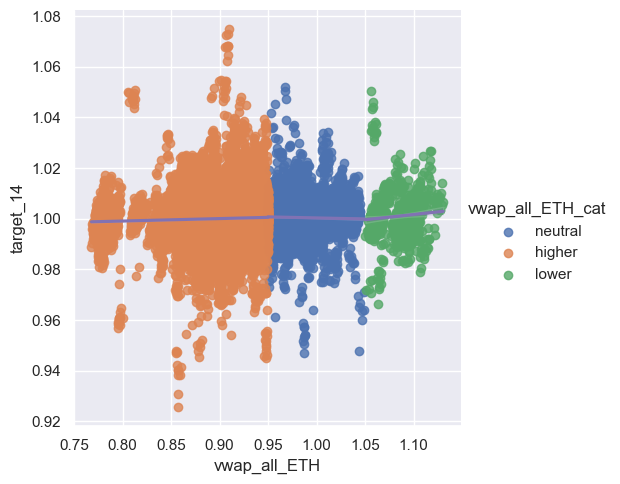

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

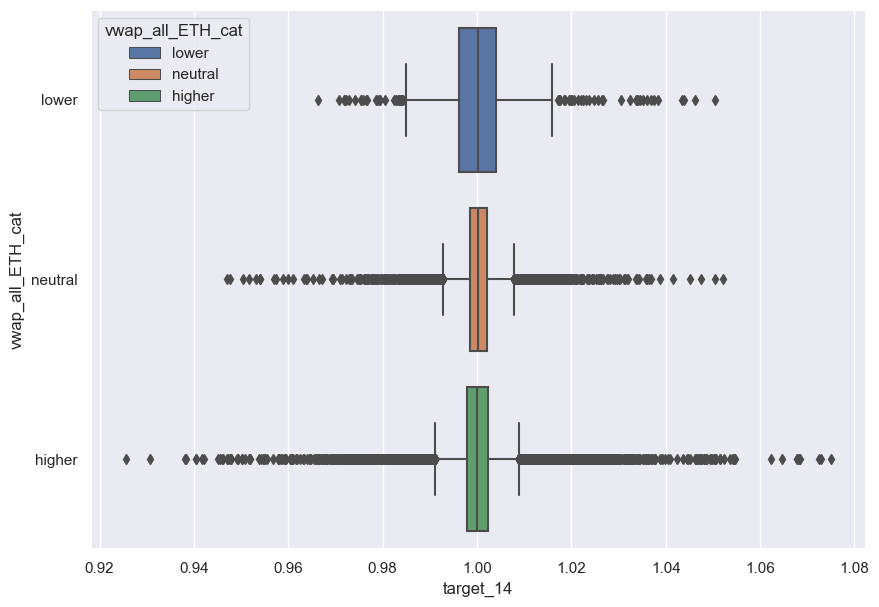

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

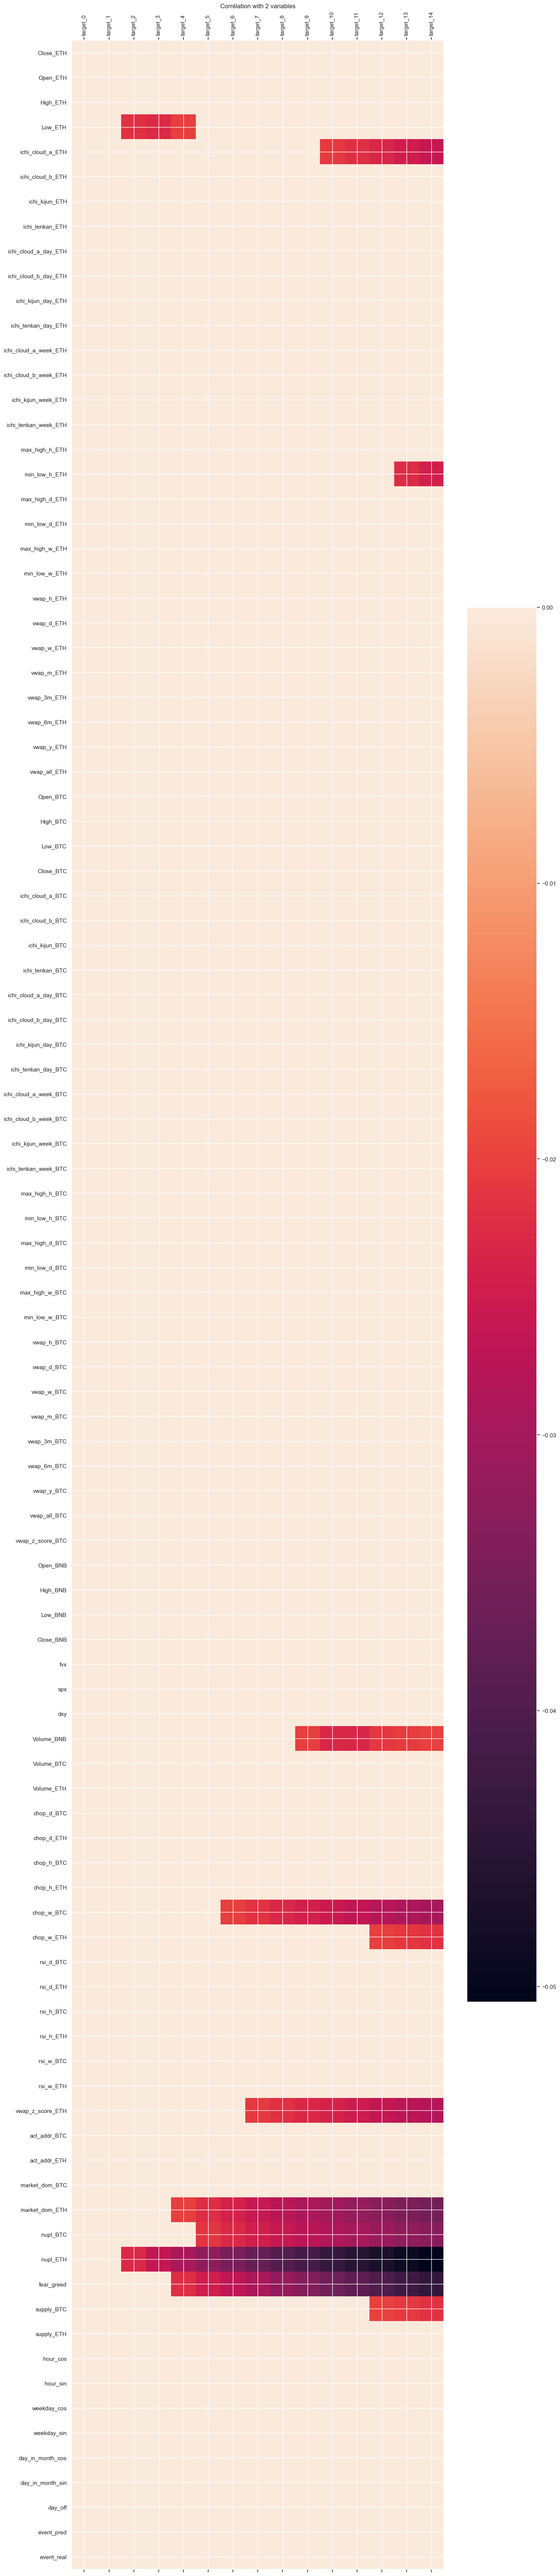

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

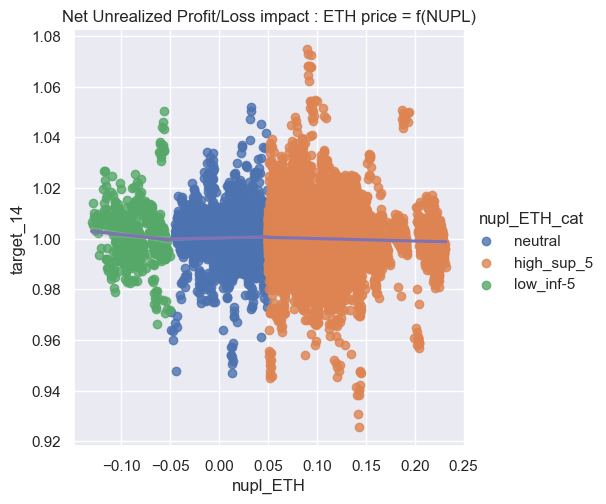

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

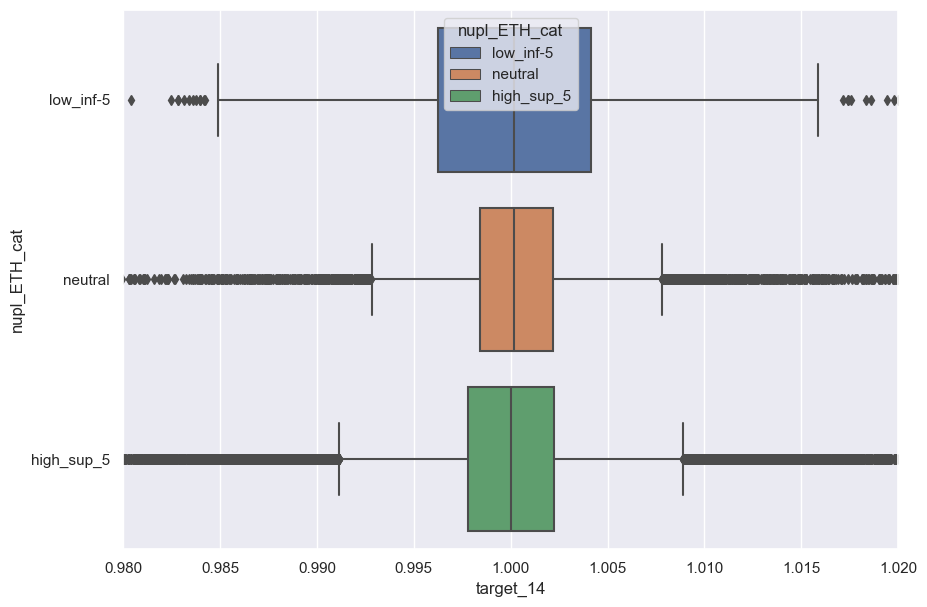

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    57272.000000
mean         1.000140
std          0.005891
min          0.925613
25%          0.997936
50%          1.000043
75%          1.002246
max          1.074927
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    57272.000000
mean         1.000019
std          0.002155
min          0.967271
25%          0.999186
50%          1.000007
75%          1.000838
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

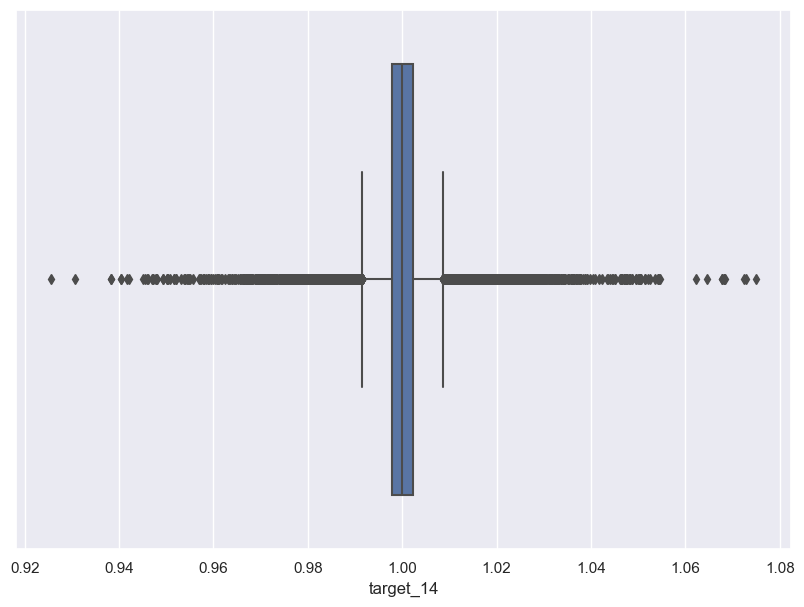

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99829855, 0.99938748, 0.99962306, ..., 1.00091093, 1.00074864,
        1.00139258],
       [1.00109079, 1.00132677, 1.00127958, ..., 1.00245427, 1.0030993 ,
        1.00223926],
       [1.00023573, 1.00018858, 1.00038241, ..., 1.00200633, 1.00114722,
        1.00187537]])

In [89]:
y_train_sca

array([[ 0.08941708,  0.07194708, -0.10469405, ..., -0.04257849,
         0.01759596, -0.05034293],
       [-0.034806  , -0.21136583, -0.0561484 , ..., -0.0891321 ,
        -0.15703973, -0.2947952 ],
       [-0.19391717, -0.03868804, -0.1492888 , ..., -0.13958697,
        -0.27735282, -0.3433252 ],
       ...,
       [-0.41186634, -0.15937207, -0.1047459 , ...,  0.19387713,
         0.15624577,  0.30555729],
       [ 0.23558057,  0.29029984,  0.27935599, ...,  0.55173634,
         0.70130234,  0.50188101],
       [ 0.0373156 ,  0.02638368,  0.07132605, ...,  0.44787027,
         0.24866623,  0.4175038 ]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(57272, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [64]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

### Save model

In [93]:
# TODO select best model


In [94]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [95]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [96]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1790/1790 [==============================] - 38s 21ms/step


(57272, 72, 102)

### Results

In [97]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

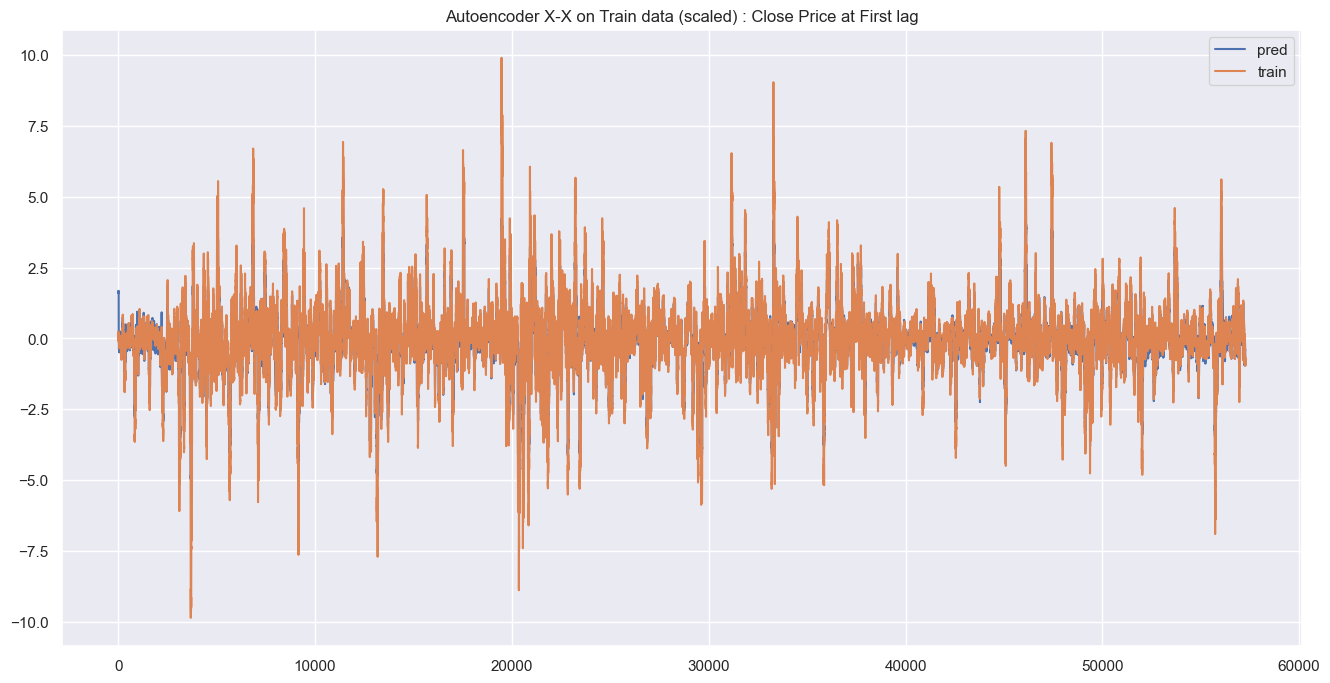

In [98]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [99]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(57272, 72, 102)
(57272, 72, 102)
(72, 102)
(1, 102)


In [100]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.216230  0.221691  0.209750  0.219242          0.304083   
lag_1    0.146501  0.147578  0.136561  0.145681          0.261025   
lag_2    0.138129  0.135157  0.126398  0.136129          0.246384   
lag_3    0.132997  0.127106  0.120726  0.129276          0.236013   
lag_4    0.131530  0.124700  0.118975  0.127377          0.229141   
...           ...       ...       ...       ...               ...   
lag_67   0.092142  0.092854  0.081179  0.090960          0.180128   
lag_68   0.091362  0.092250  0.080415  0.090237          0.180018   
lag_69   0.090606  0.091630  0.079705  0.089477          0.179904   
lag_70   0.089893  0.090968  0.078993  0.088741          0.179780   
lag_71   0.088874  0.090639  0.078218  0.087924          0.179647   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.333607        0.234176         0.234655   
lag_1           0.290659        0.164063         0.160775   
lag_2           0.275508        0.146402         0.143585   
lag_3           0.265283        0.139059         0.132987   
lag_4           0.257645        0.135016         0.127072   
...                  ...             ...              ...   
lag_67          0.196981        0.111298         0.088840   
lag_68          0.196856        0.111016         0.088412   
lag_69          0.196735        0.110702         0.087983   
lag_70          0.196619        0.110405         0.087498   
lag_71          0.196498        0.110111         0.087000   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.308343              0.242032  ...    0.359065  0.686129   
lag_1               0.236231              0.180240  ...    0.269775  0.519082   
lag_2               0.211638              0.156804  ...    0.230085  0.438584   
lag_3               0.194819              0.144320  ...    0.201387  0.383984   
lag_4               0.184949              0.137507  ...    0.182176  0.348467   
...                      ...                   ...  ...         ...       ...   
lag_67              0.151008              0.115276  ...    0.133070  0.223715   
lag_68              0.150926              0.115222  ...    0.133002  0.223523   
lag_69              0.150840              0.115145  ...    0.132954  0.223335   
lag_70              0.150771              0.115099  ...    0.132886  0.223146   
lag_71              0.150683              0.115006  ...    0.132828  0.222959   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.707525     0.626819     0.653960          0.640179   
lag_1   0.576972     0.425891     0.490718          0.504134   
lag_2   0.511175     0.346222     0.429918          0.440681   
lag_3   0.462653     0.306411     0.392981          0.400739   
lag_4   0.425692     0.283145     0.369193          0.369603   
...          ...          ...          ...               ...   
lag_67  0.234884     0.222466     0.269587          0.204607   
lag_68  0.234745     0.222316     0.269436          0.204600   
lag_69  0.234602     0.222156     0.269302          0.204586   
lag_70  0.234496     0.222008     0.269165          0.204603   
lag_71  0.234354     0.221873     0.269027          0.204616   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.630108  0.394601    0.035403    0.039671  
lag_1           0.479761  0.306733    0.036422    0.038727  
lag_2           0.410133  0.212644    0.033697    0.036319  
lag_3           0.364347  0.160170    0.032820    0.035169  
lag_4           0.332427  0.128997    0.032329    0.034552  
...                  ...       ...         ...         ...  
lag_67          0.205045  0.081052    0.031128    0.032979  
lag_68          0.204942  0.080943    0.031118    0.032927  
lag_69          0.204808  0.080839    0.031112    0.032875  
lag_70          0.204705  0.080745    0.031107    0.032825  
lag_71          0.204610  0.08063

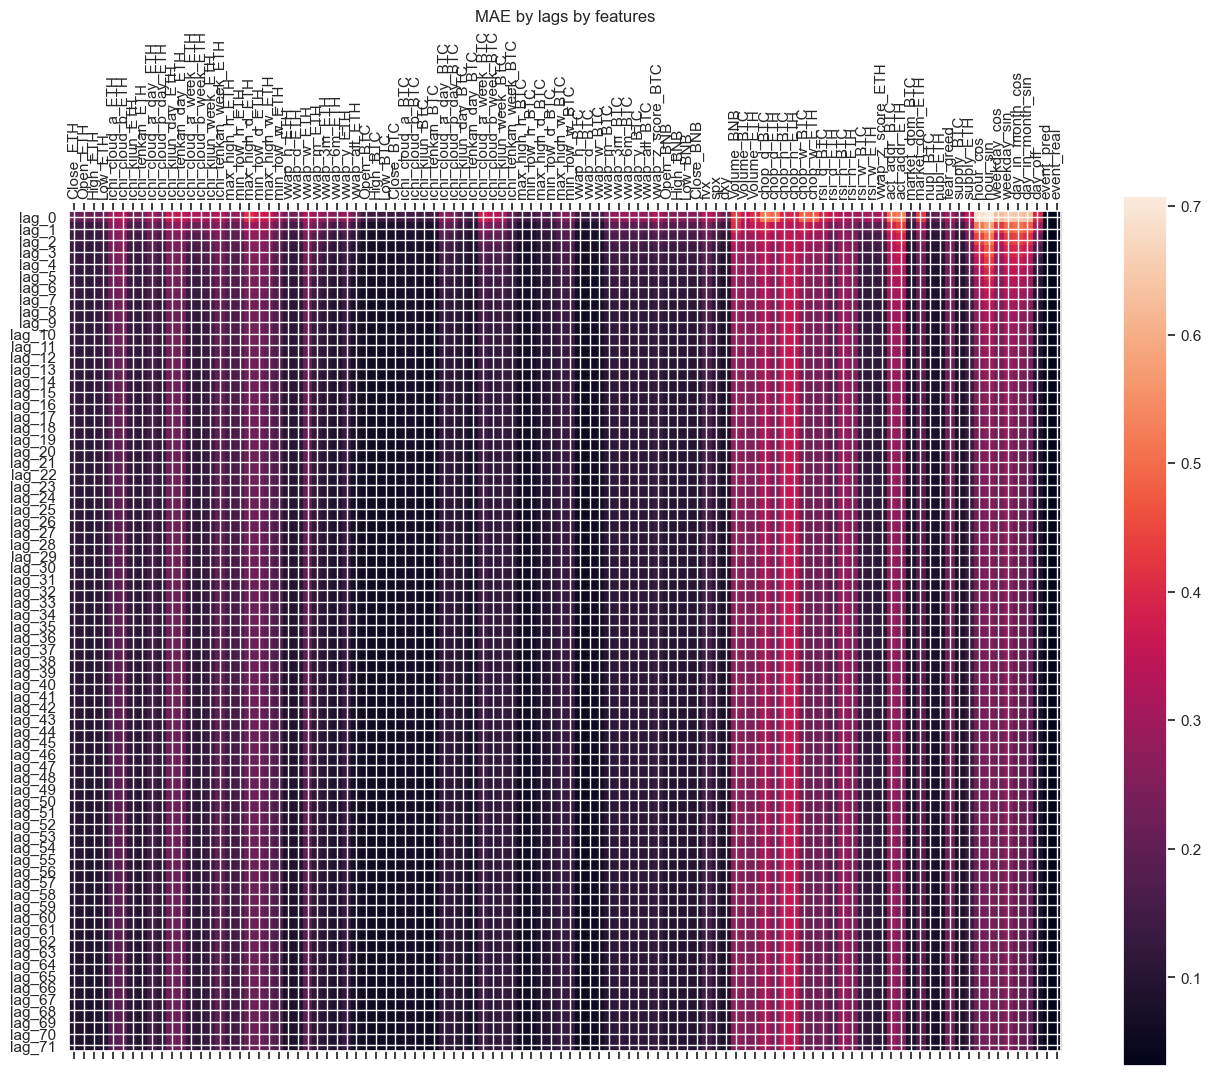

In [101]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

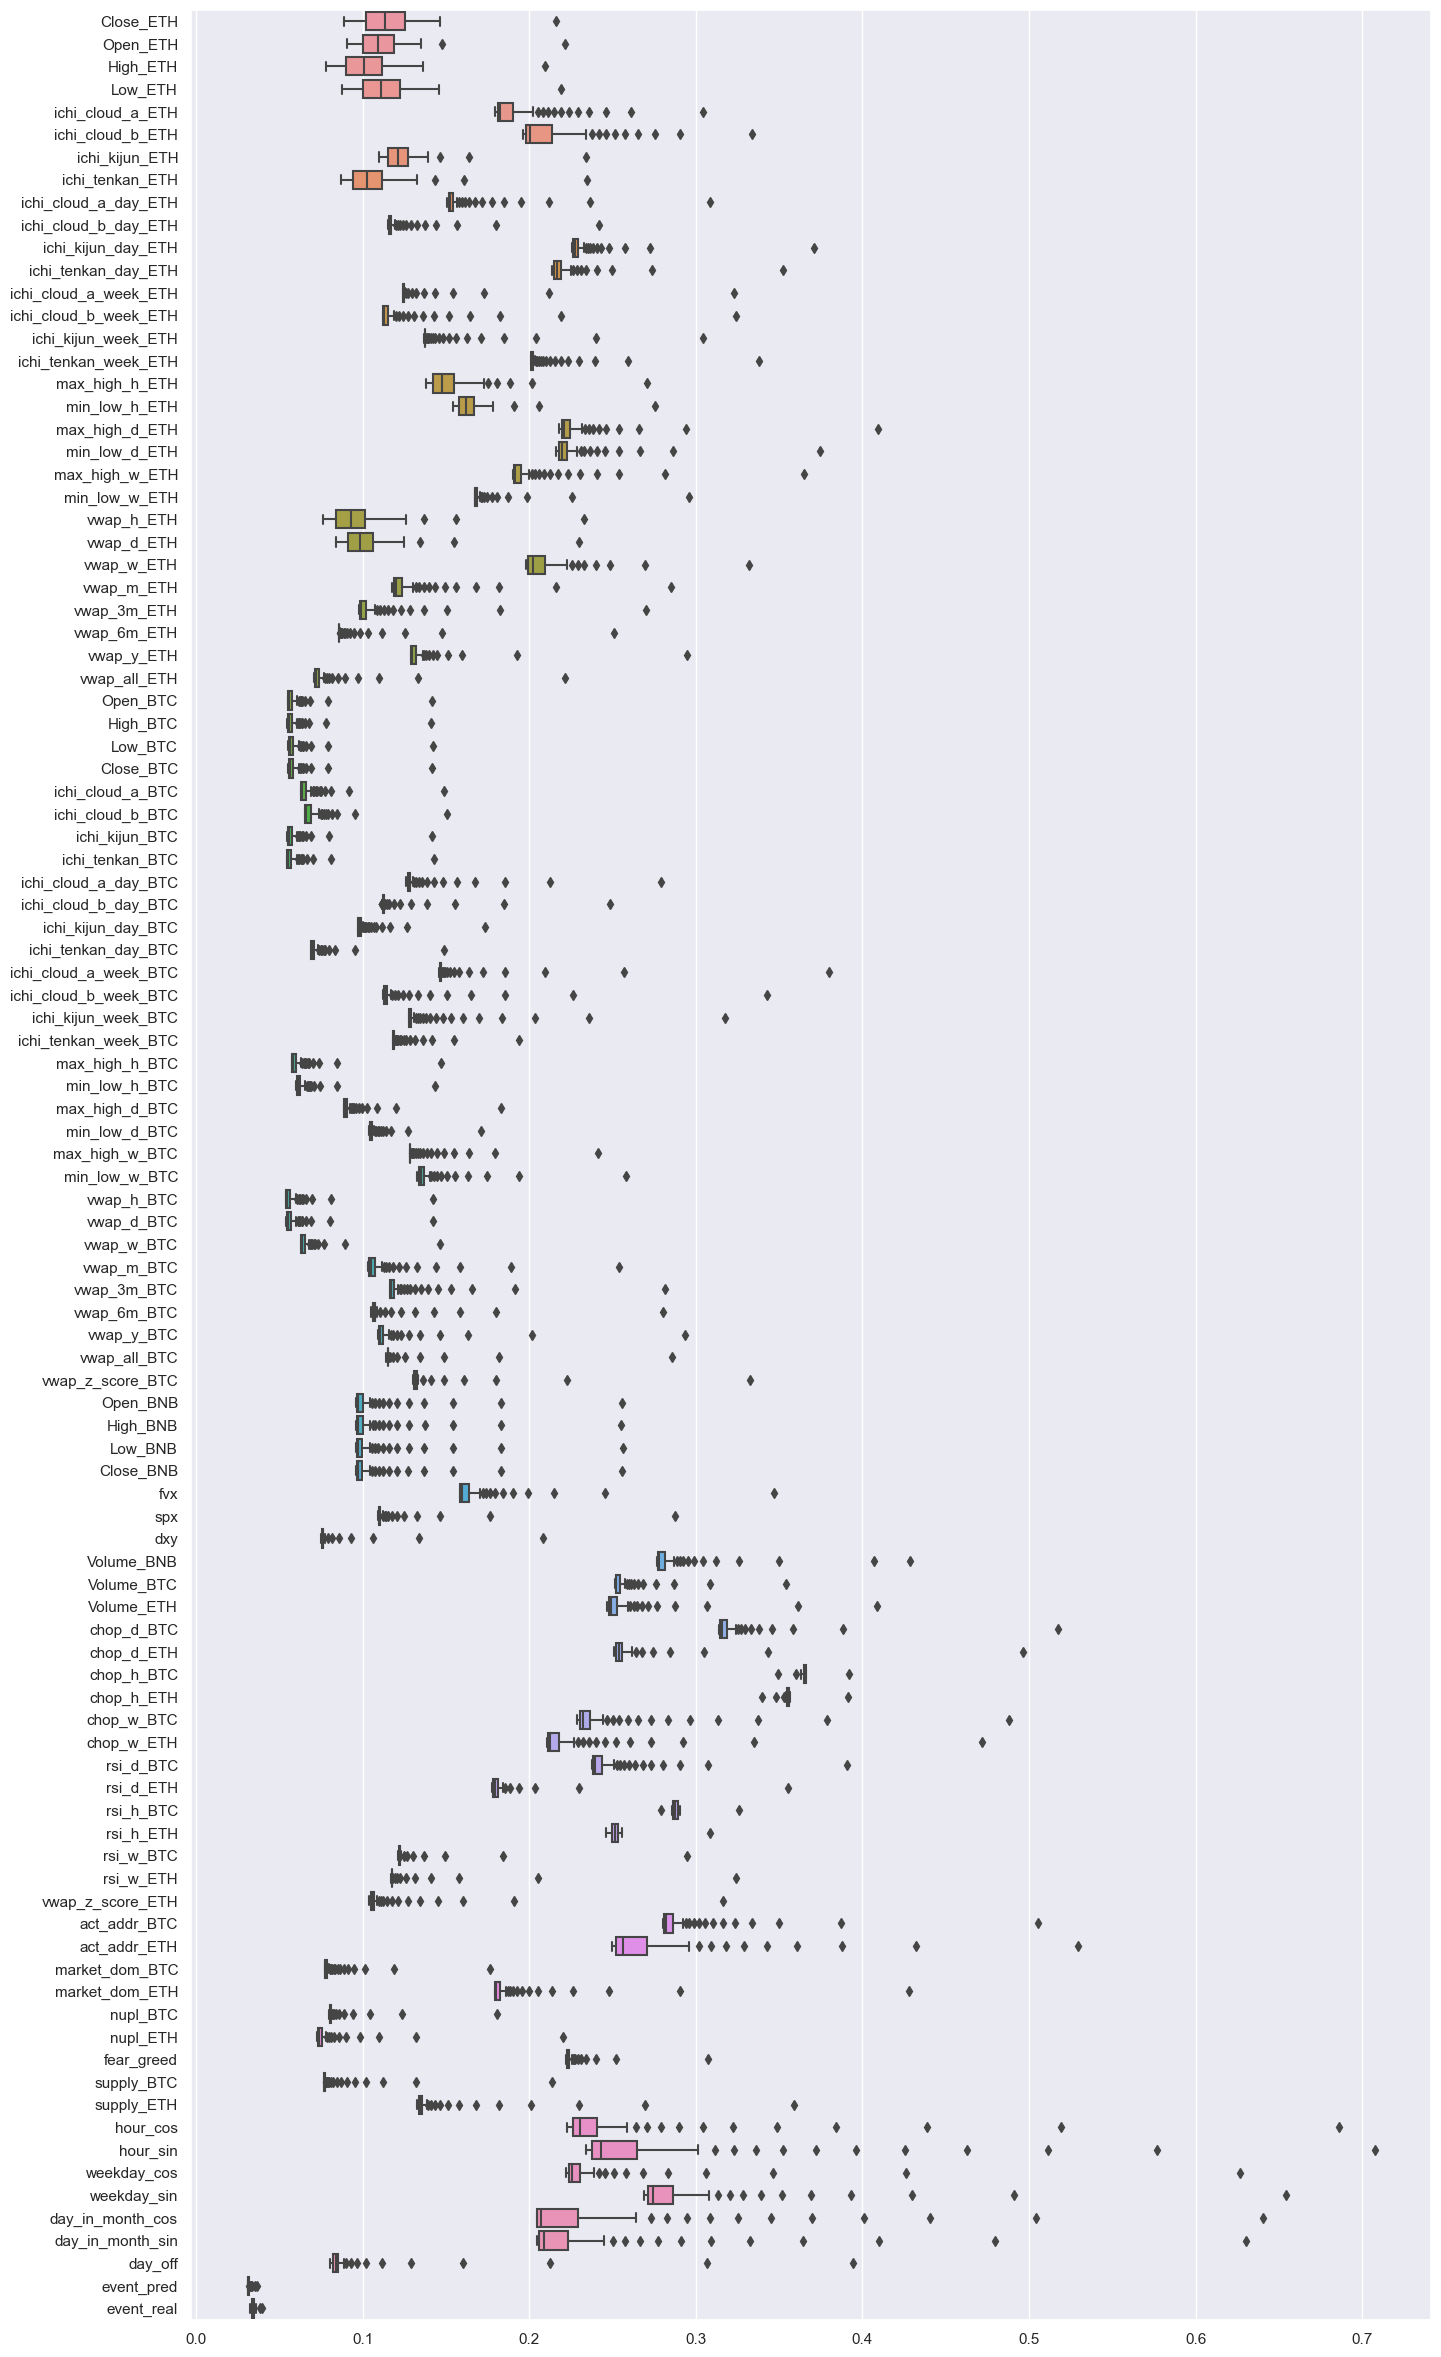

In [102]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [103]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.114744  0.111133  0.102313  0.112271          0.191335   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.211507        0.123609         0.106203              0.159018   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.120936  ...    0.144007  0.252893  0.275458     0.240006   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0     0.293765          0.238266          0.233034  0.09552    0.031635   

   event_real  
0    0.034335  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

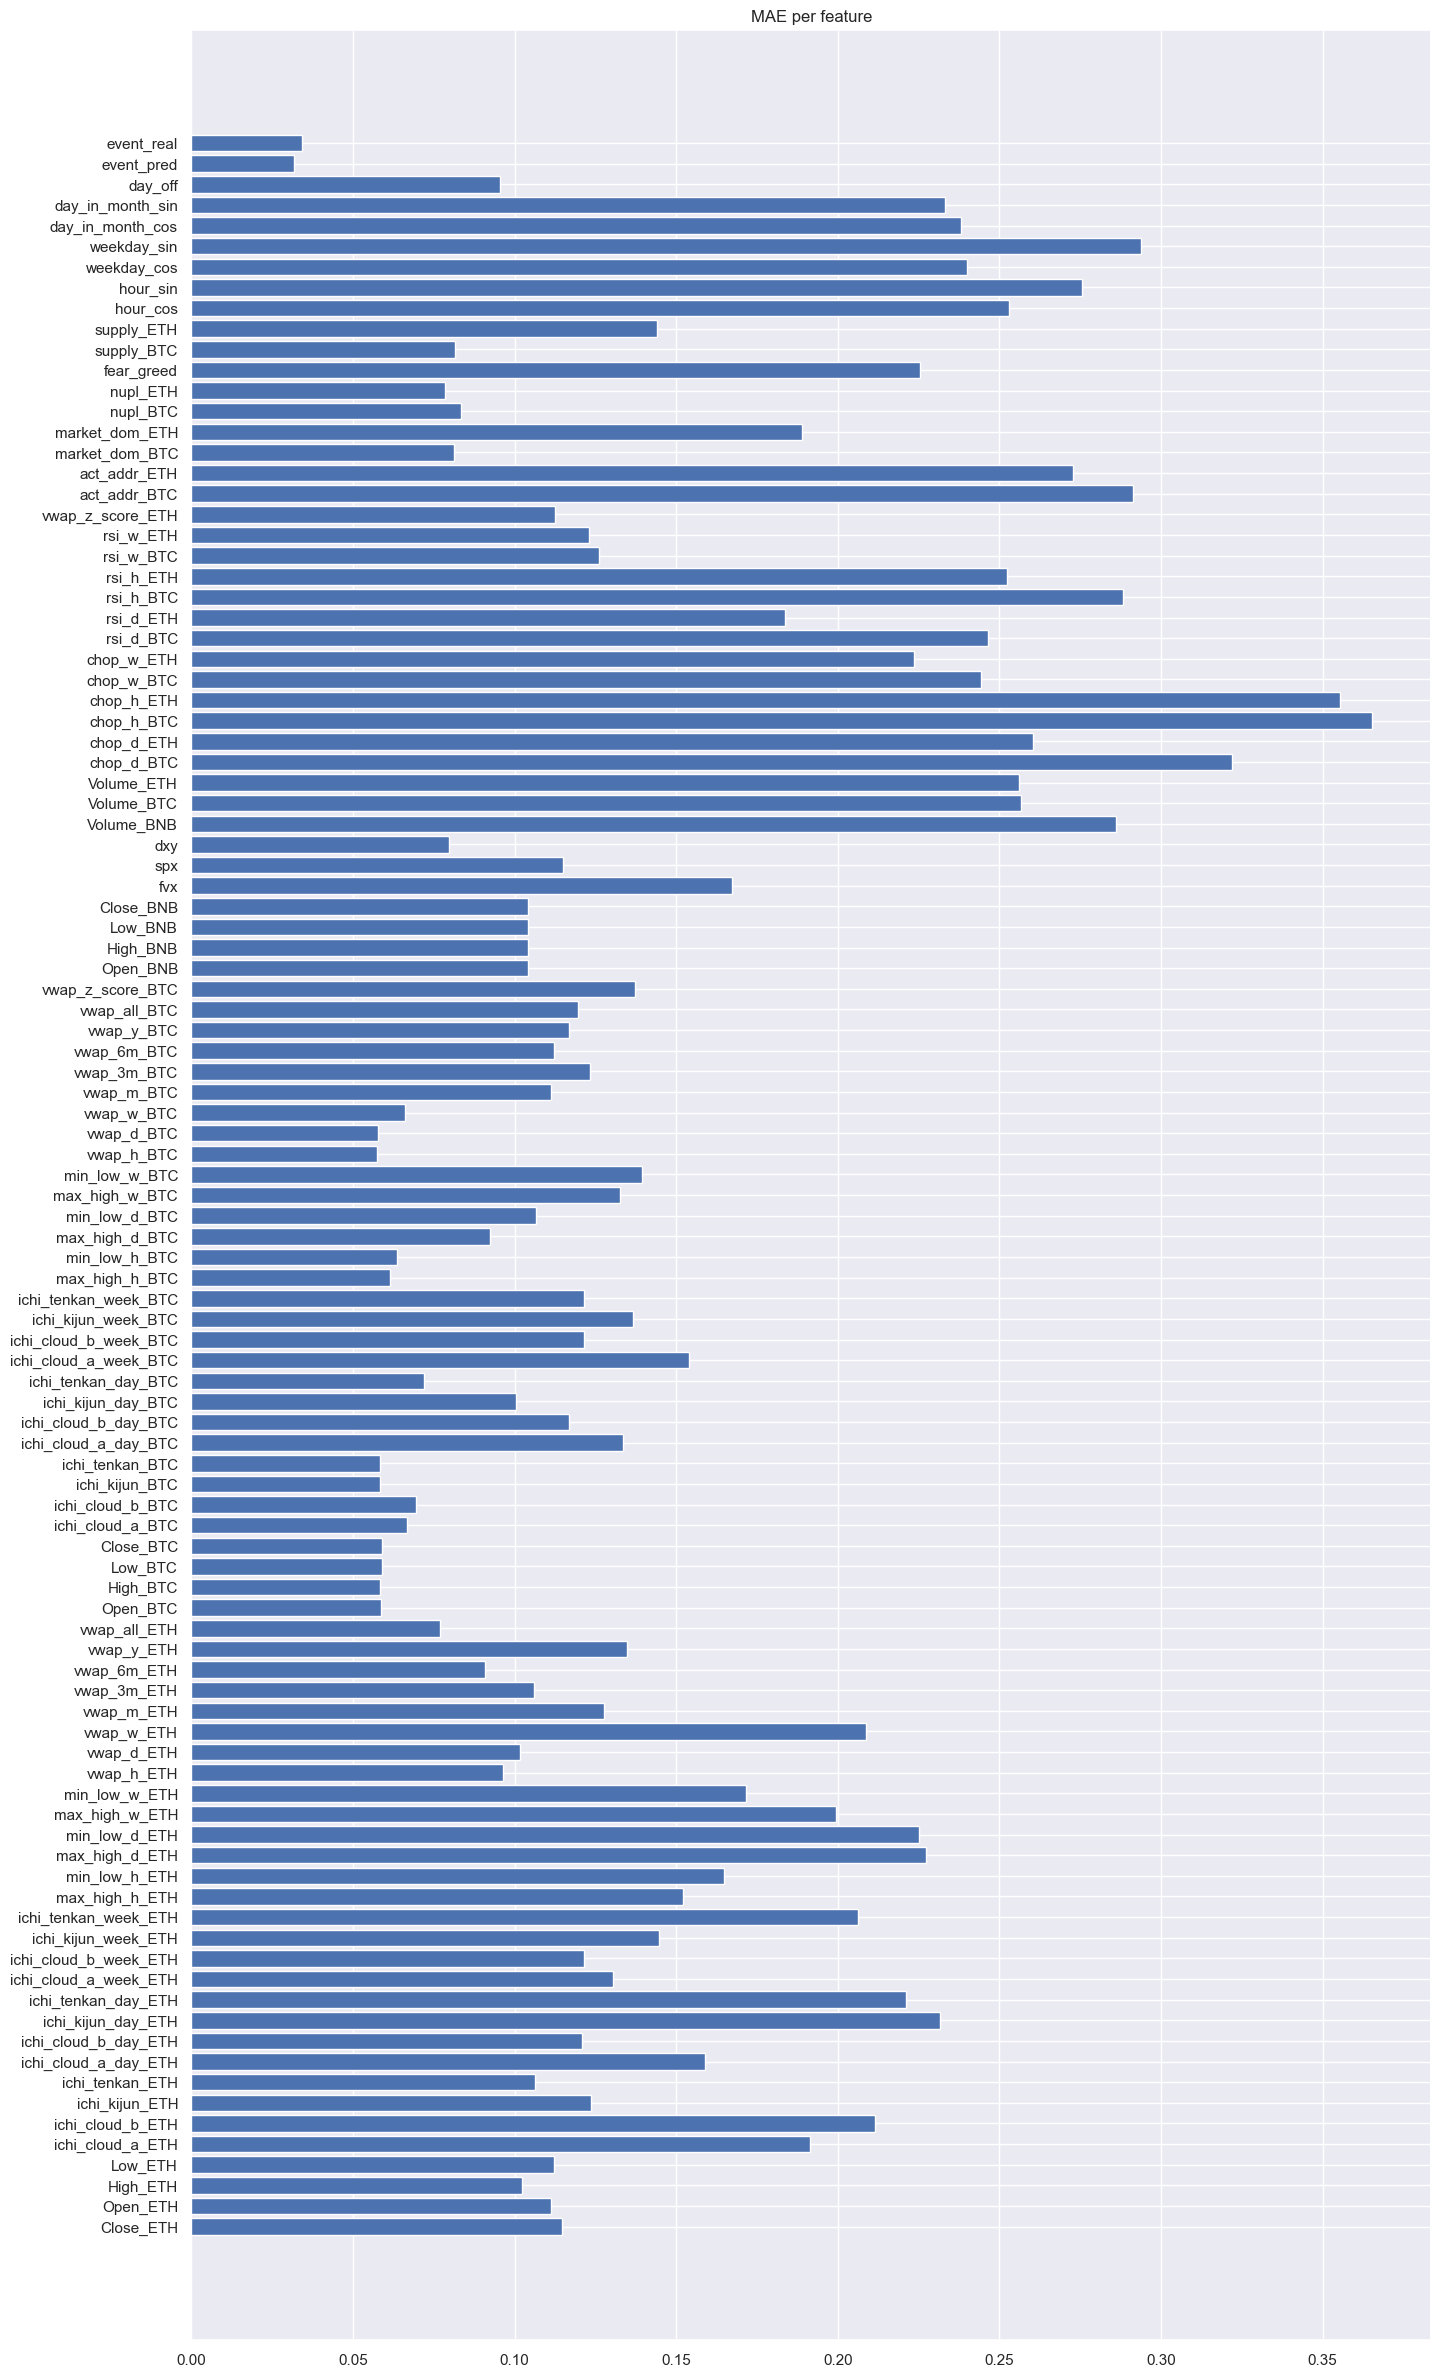

In [104]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [105]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(57272,)
(57272,)
[1196.32 1195.38 1194.55 ... 1892.75 1894.64 1894.17]
[1196.32 1195.38 1194.55]


In [106]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9997538, 1.0001206, 0.9997435, ..., 0.999445 , 1.0005821,
       0.9992351], dtype=float32)

[1196.32 1195.38 1194.55 ... 1892.75 1894.64 1894.17]
[1211.82027213 1212.36455173 1212.2127074  ... 1894.18220809 1893.68499674
 1895.86711747]


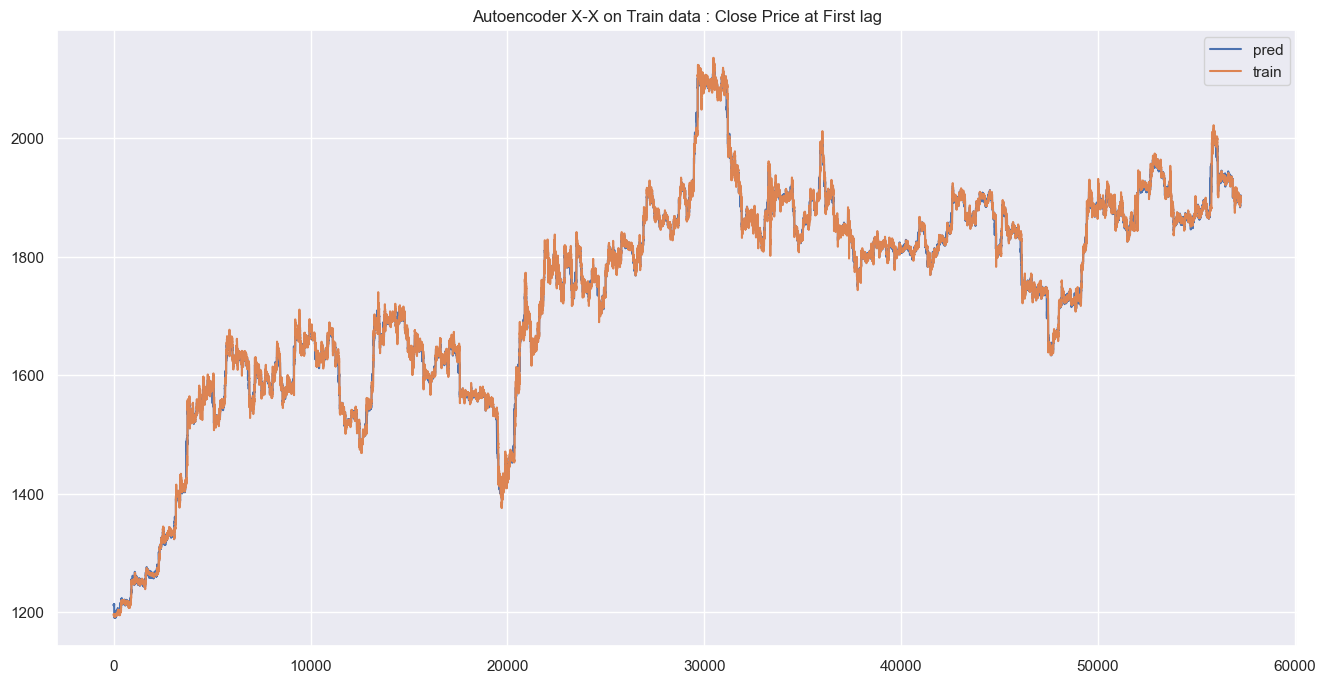

In [107]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [108]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

446/446 [==============================] - 10s 22ms/step


(14251, 72, 102)

In [109]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-19 03:50:00'

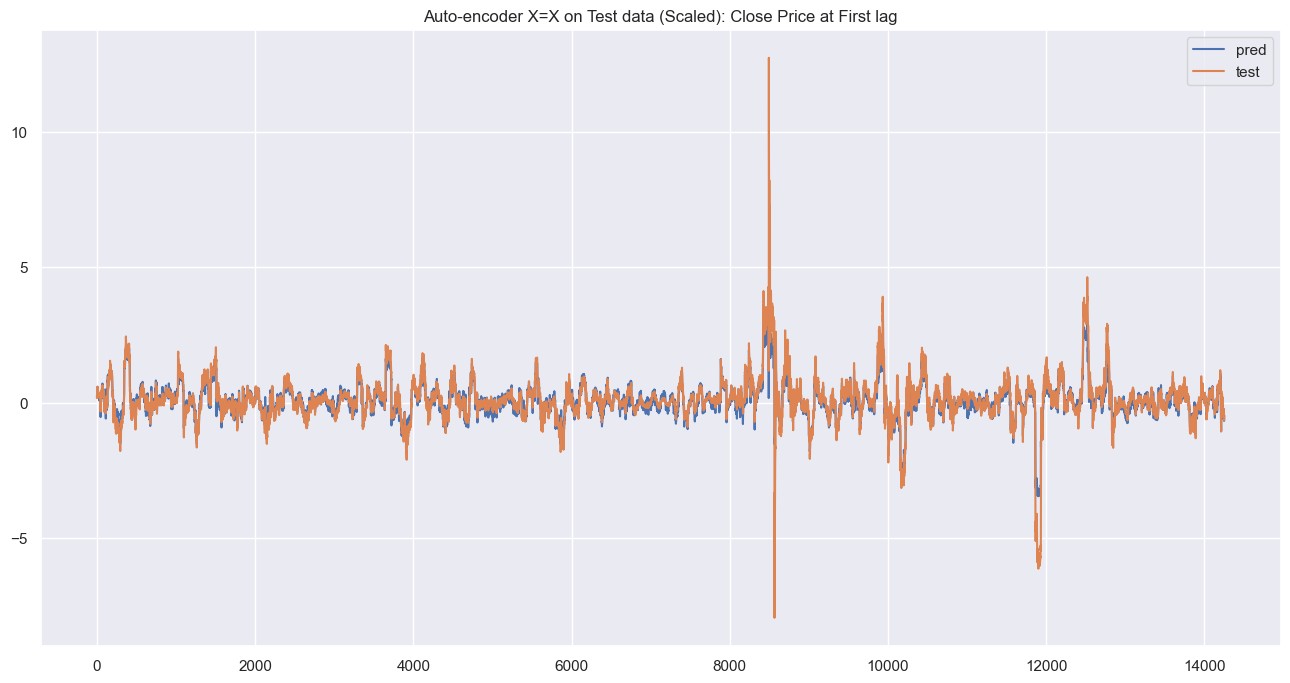

In [110]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [111]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1912.48 1913.63 1915.13 1913.54 1916.6  1916.54 1915.36 1917.88 1916.21]
X test pred :  [1913.20221252 1914.30814161 1916.05948423 1915.39560805 1917.9764524
 1918.2644012  1916.5273411  1917.85042428 1917.8044392 ]


[1912.48 1913.63 1915.13 ... 1621.32 1623.93 1624.21]
[1913.20221252 1914.30814161 1916.05948423 ... 1620.97162687 1623.18825901
 1624.04619816]


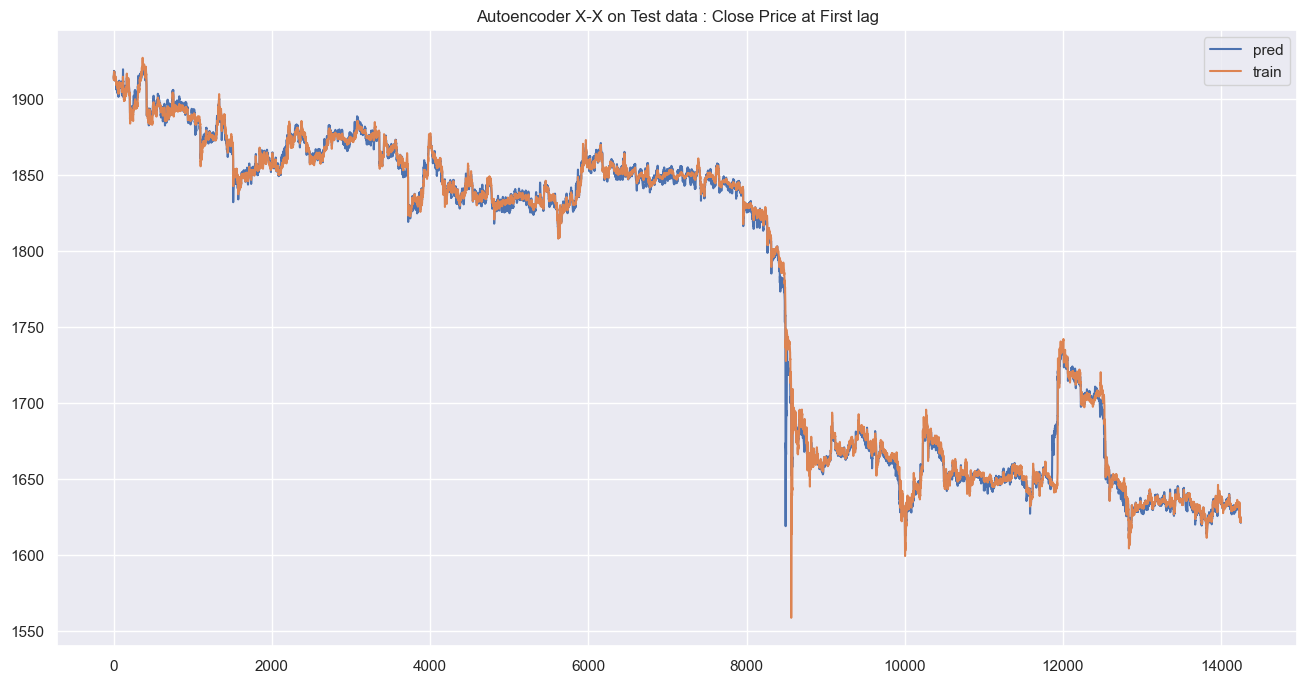

In [112]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [113]:
X_test_sca.shape

(14251, 72, 102)

In [114]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.40763630963046954

In [115]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(14251, 72, 102)
(14251, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.216230  0.221691  0.209750  0.219242          0.304083   
lag_1    0.146501  0.147578  0.136561  0.145681          0.261025   
lag_2    0.138129  0.135157  0.126398  0.136129          0.246384   
lag_3    0.132997  0.127106  0.120726  0.129276          0.236013   
lag_4    0.131530  0.124700  0.118975  0.127377          0.229141   
...           ...       ...       ...       ...               ...   
lag_67   0.113702  0.113173  0.110832  0.118272          0.166036   
lag_68   0.112856  0.112598  0.110257  0.117523          0.165907   
lag_69   0.112061  0.111839  0.109466  0.116774          0.165768   
lag_70   0.111393  0.111132  0.108797  0.115950          0.165557   
lag_71   0.110348  0.110376  0.108199  0.114925          0.165385   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.333607        0.234176         0.234655   
lag_1           0.290659        0.164063         0.160775   
lag_2           0.275508        0.146402         0.143585   
lag_3           0.265283        0.139059         0.132987   
lag_4           0.257645        0.135016         0.127072   
...                  ...             ...              ...   
lag_67          0.178967        0.096951         0.105283   
lag_68          0.178705        0.096398         0.104720   
lag_69          0.178454        0.095802         0.104100   
lag_70          0.178182        0.095094         0.103380   
lag_71          0.177960        0.094178         0.102421   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.308343              0.242032  ...  0.686129  0.707525   
lag_1               0.236231              0.180240  ...  0.519082  0.576972   
lag_2               0.211638              0.156804  ...  0.438584  0.511175   
lag_3               0.194819              0.144320  ...  0.383984  0.462653   
lag_4               0.184949              0.137507  ...  0.348467  0.425692   
...                      ...                   ...  ...       ...       ...   
lag_67              0.236117              0.262524  ...  0.313197  0.292288   
lag_68              0.236118              0.262526  ...  0.313065  0.292201   
lag_69              0.236130              0.262534  ...  0.312993  0.292035   
lag_70              0.236132              0.262557  ...  0.312918  0.291878   
lag_71              0.236117              0.262564  ...  0.312793  0.291695   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.626819     0.653960          0.640179          0.630108   
lag_1      0.425891     0.490718          0.504134          0.479761   
lag_2      0.346222     0.429918          0.440681          0.410133   
lag_3      0.306411     0.392981          0.400739          0.364347   
lag_4      0.283145     0.369193          0.369603          0.332427   
...             ...          ...               ...               ...   
lag_67     0.353088     0.460708          0.810308          0.702894   
lag_68     0.353067     0.460625          0.810298          0.702947   
lag_69     0.353039     0.460507          0.810294          0.703000   
lag_70     0.353079     0.460397          0.810277          0.703044   
lag_71     0.353089     0.460325          0.810207          0.703109   

         day_off  event_pred  event_real  dataset  
lag_0   0.394601    0.035403    0.039671    TRAIN  
lag_1   0.306733    0.036422    0.038727    TRAIN  
lag_2   0.212644    0.033697    0.036319    TRAIN  
lag_3   0.160170    0.032820    0.035169    TRAIN  
lag_4   0.128997    0.032329    0.034552    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.146309    0.027667    0.022730     TEST  
lag_68  0.146285    0.027669    0.022696     TEST  
lag_69  0.146350    0.027667    0.022668     TEST  
lag_70  0.146381    0.027666    0.022634     TEST  
lag_71  0.146402    0.027672    0.022590     TEST  

[144 ro

In [116]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0    0.12494  0.122093  0.119846  0.129548          0.167685   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.182709        0.108965         0.114577               0.24348   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.266481  ...    0.303906  0.334971  0.321199     0.360471   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.461218          0.810305          0.707505  0.156405    0.027005   

   event_real  
0    0.023032  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

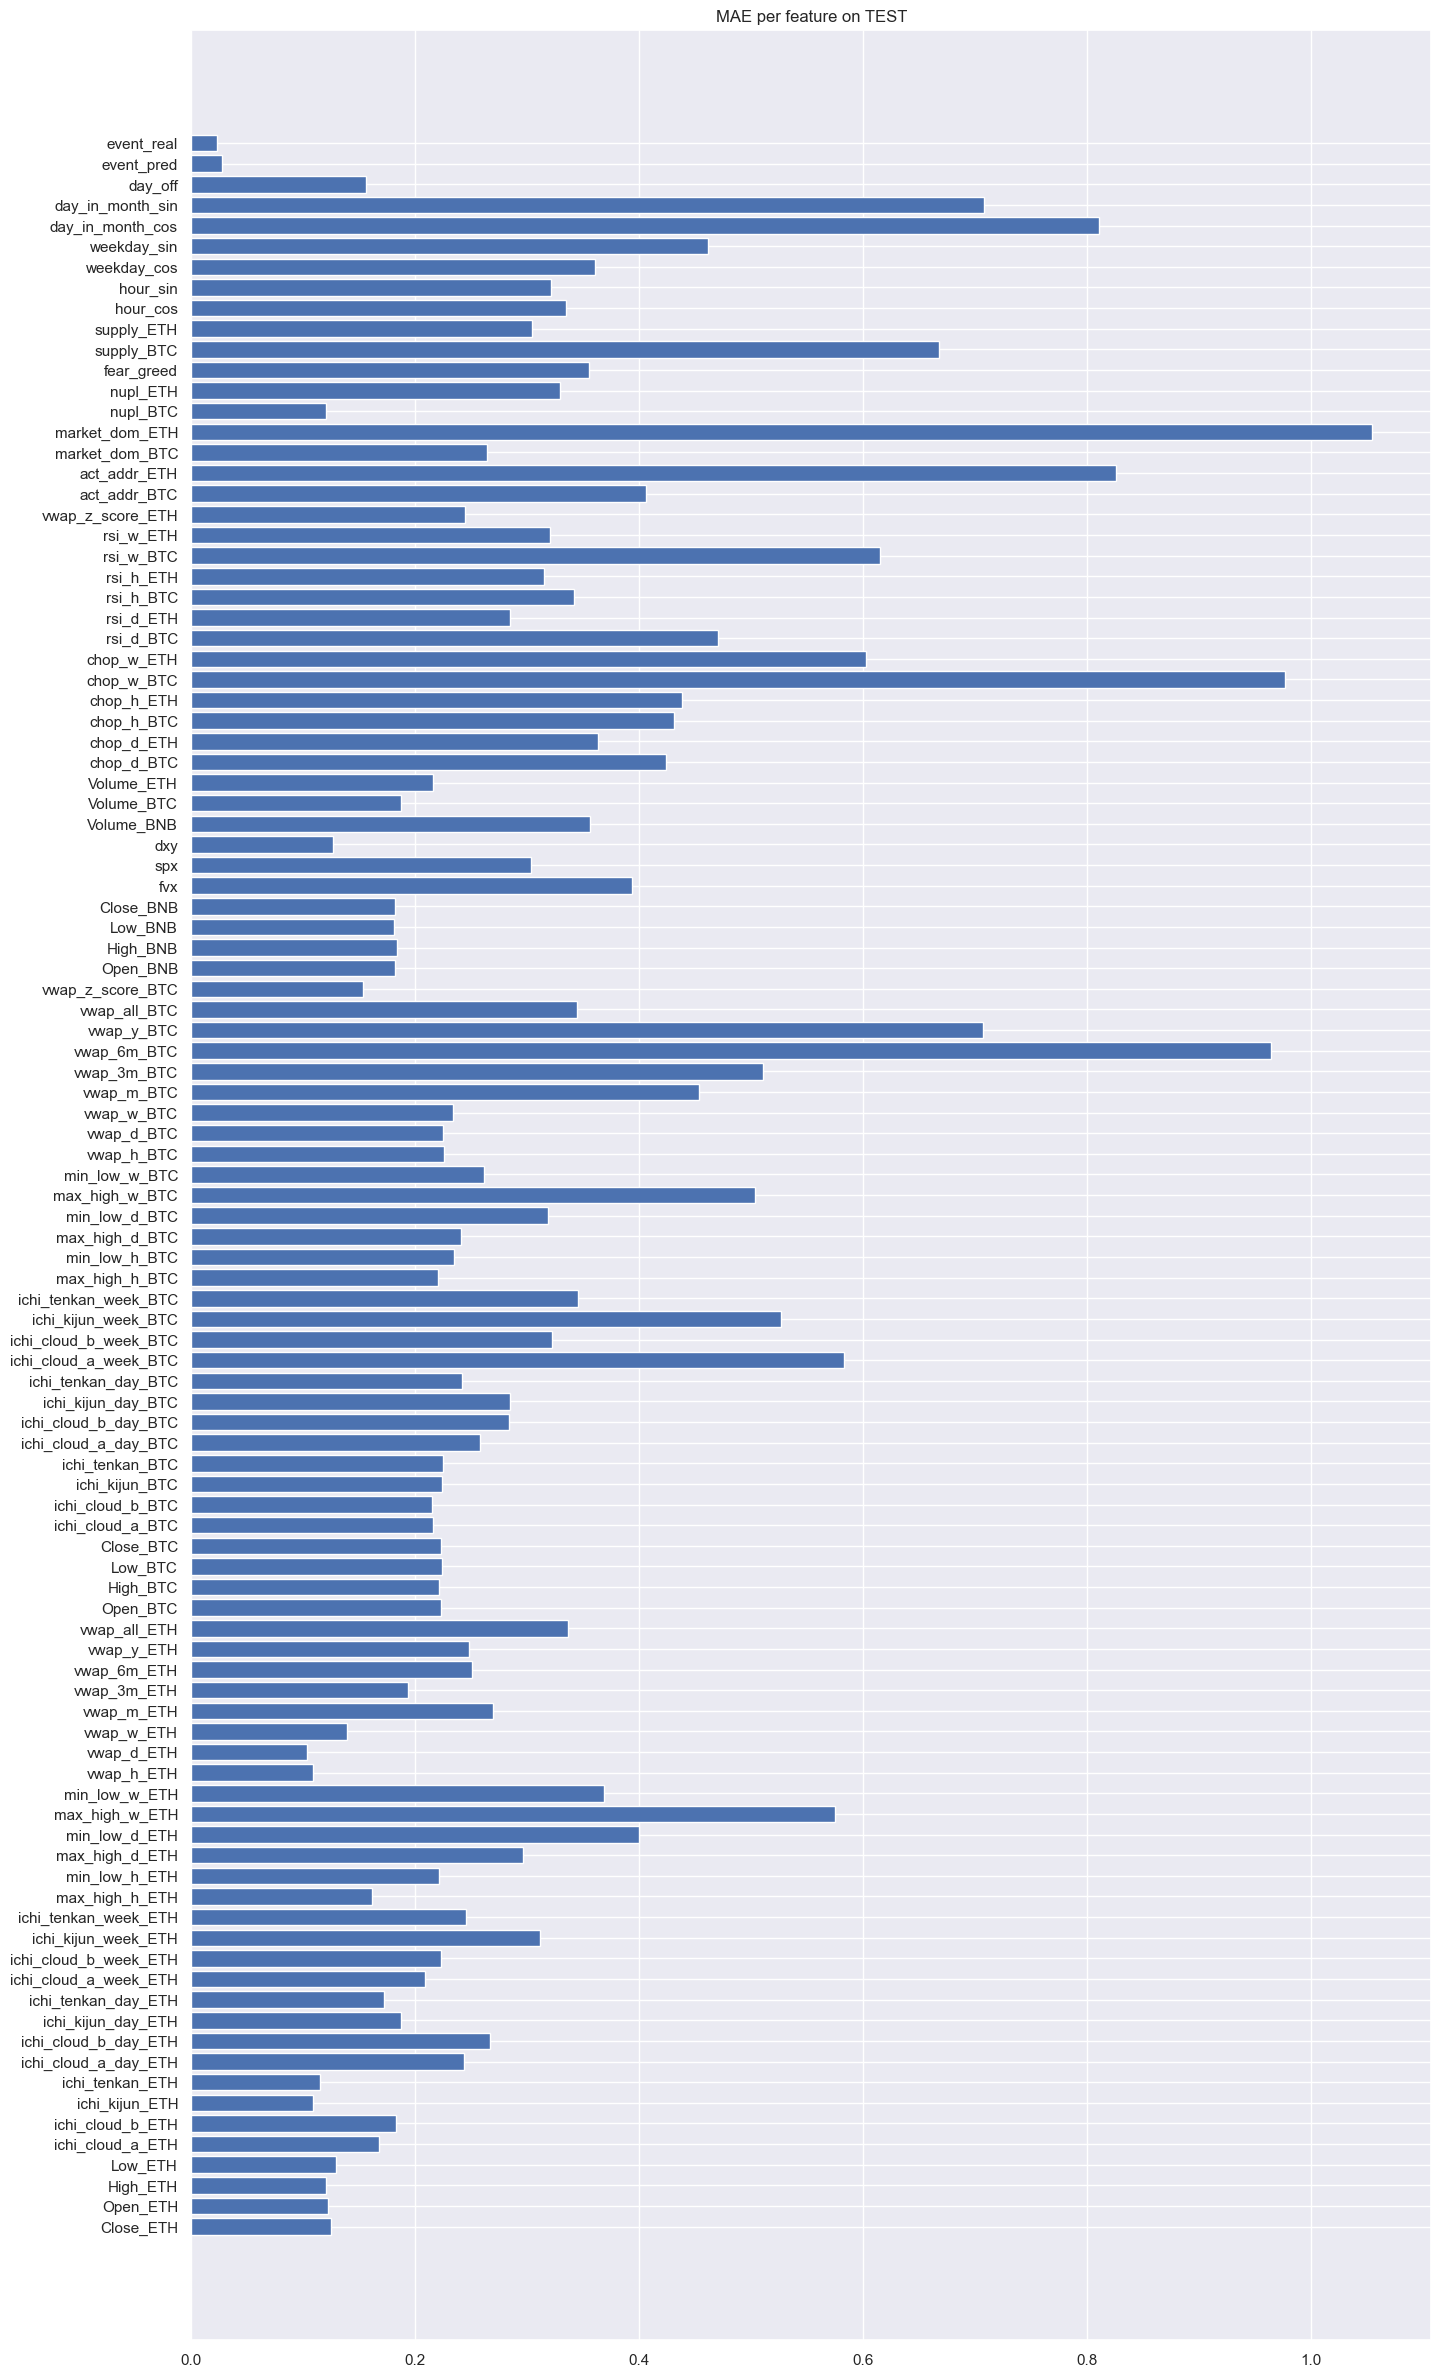

In [117]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [118]:
df_mae_ae_test_feat.values[0]

array([0.1249395 , 0.12209331, 0.11984558, 0.12954816, 0.16768528,
       0.18270871, 0.10896512, 0.11457663, 0.24347972, 0.26648129,
       0.18720359, 0.1719184 , 0.20864589, 0.22263918, 0.31114243,
       0.24567723, 0.1615263 , 0.22076613, 0.29596329, 0.39996566,
       0.57485855, 0.36850034, 0.10845415, 0.10347649, 0.13868059,
       0.26978052, 0.19395741, 0.25025686, 0.24759783, 0.33607323,
       0.22302662, 0.22117339, 0.22388339, 0.22259471, 0.21571579,
       0.21534858, 0.22364401, 0.22490546, 0.25811908, 0.28378223,
       0.28464308, 0.24203165, 0.58301325, 0.32226731, 0.52656949,
       0.34517444, 0.22022278, 0.23491218, 0.24078249, 0.31850822,
       0.50383411, 0.2612654 , 0.22527233, 0.22444681, 0.23374276,
       0.45309674, 0.51060621, 0.96444784, 0.7070464 , 0.34440671,
       0.15320487, 0.18213239, 0.18324534, 0.18130856, 0.18214233,
       0.39336995, 0.30336359, 0.12615628, 0.35630299, 0.18696339,
       0.21571248, 0.42429997, 0.36275254, 0.43107676, 0.43860

In [119]:
2/df_mae_ae_test_feat.values[0].sum()

0.06158385597501306

In [120]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.216230
1       TRAIN   Close_ETH  0.146501
2       TRAIN   Close_ETH  0.138129
3       TRAIN   Close_ETH  0.132997
4       TRAIN   Close_ETH  0.131530
...       ...         ...       ...
14683    TEST  event_real  0.022730
14684    TEST  event_real  0.022696
14685    TEST  event_real  0.022668
14686    TEST  event_real  0.022634
14687    TEST  event_real  0.022590

[14688 rows x 3 columns]

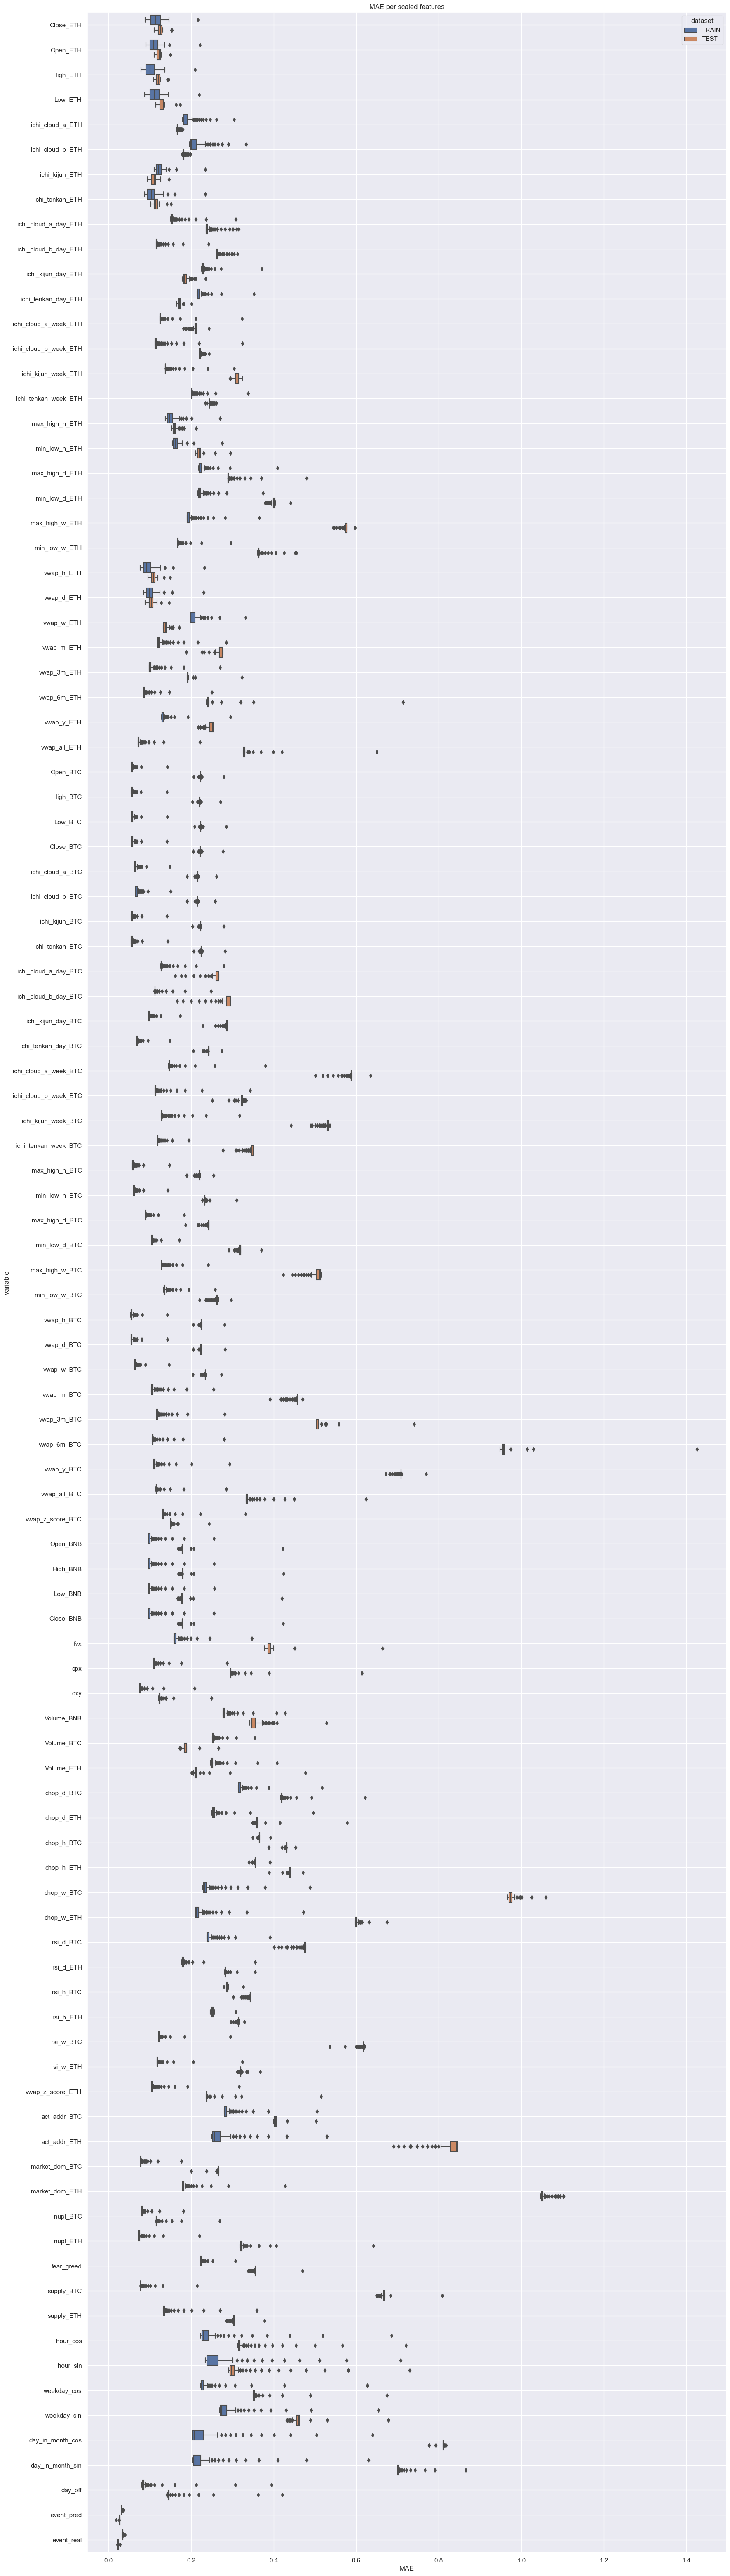

In [121]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [122]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(57272, 72, 102)
(57272, 72, 102)
(72, 102)
(14251, 72, 102)
(14251, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [123]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.031822  0.030185  0.026265  0.030191          0.150392   
0   0.037701  0.035485  0.031480  0.040665          0.063564   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.150243        0.033705         0.026090              0.049427   
0          0.079012        0.032650         0.030281              0.092893   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.032050  ...  0.097002  0.116771     0.084839     0.128144   
0              0.107495  ...  0.172252  0.159120     0.183880     0.315363   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0           0.09131          0.084645  0.088291    0.998716    0.998251   
0           0.89670          0.682601  0.082913    0.268519    0.669701   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

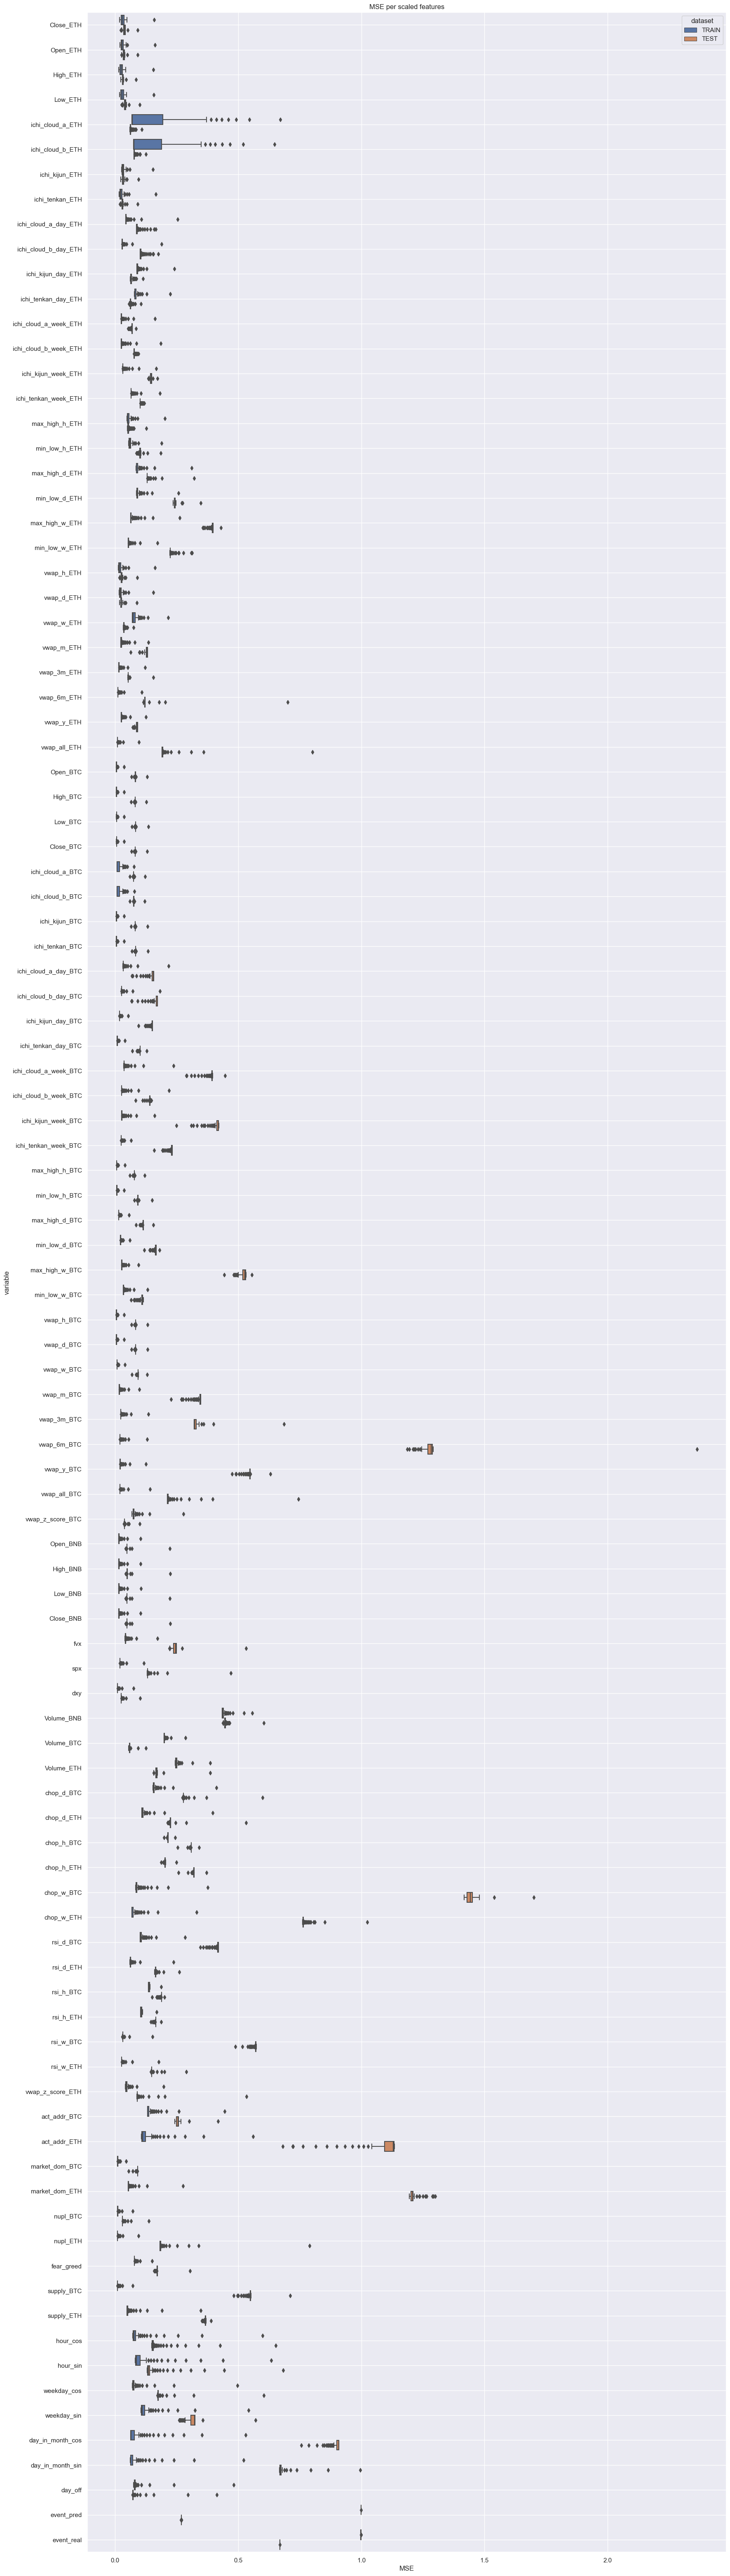

In [124]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

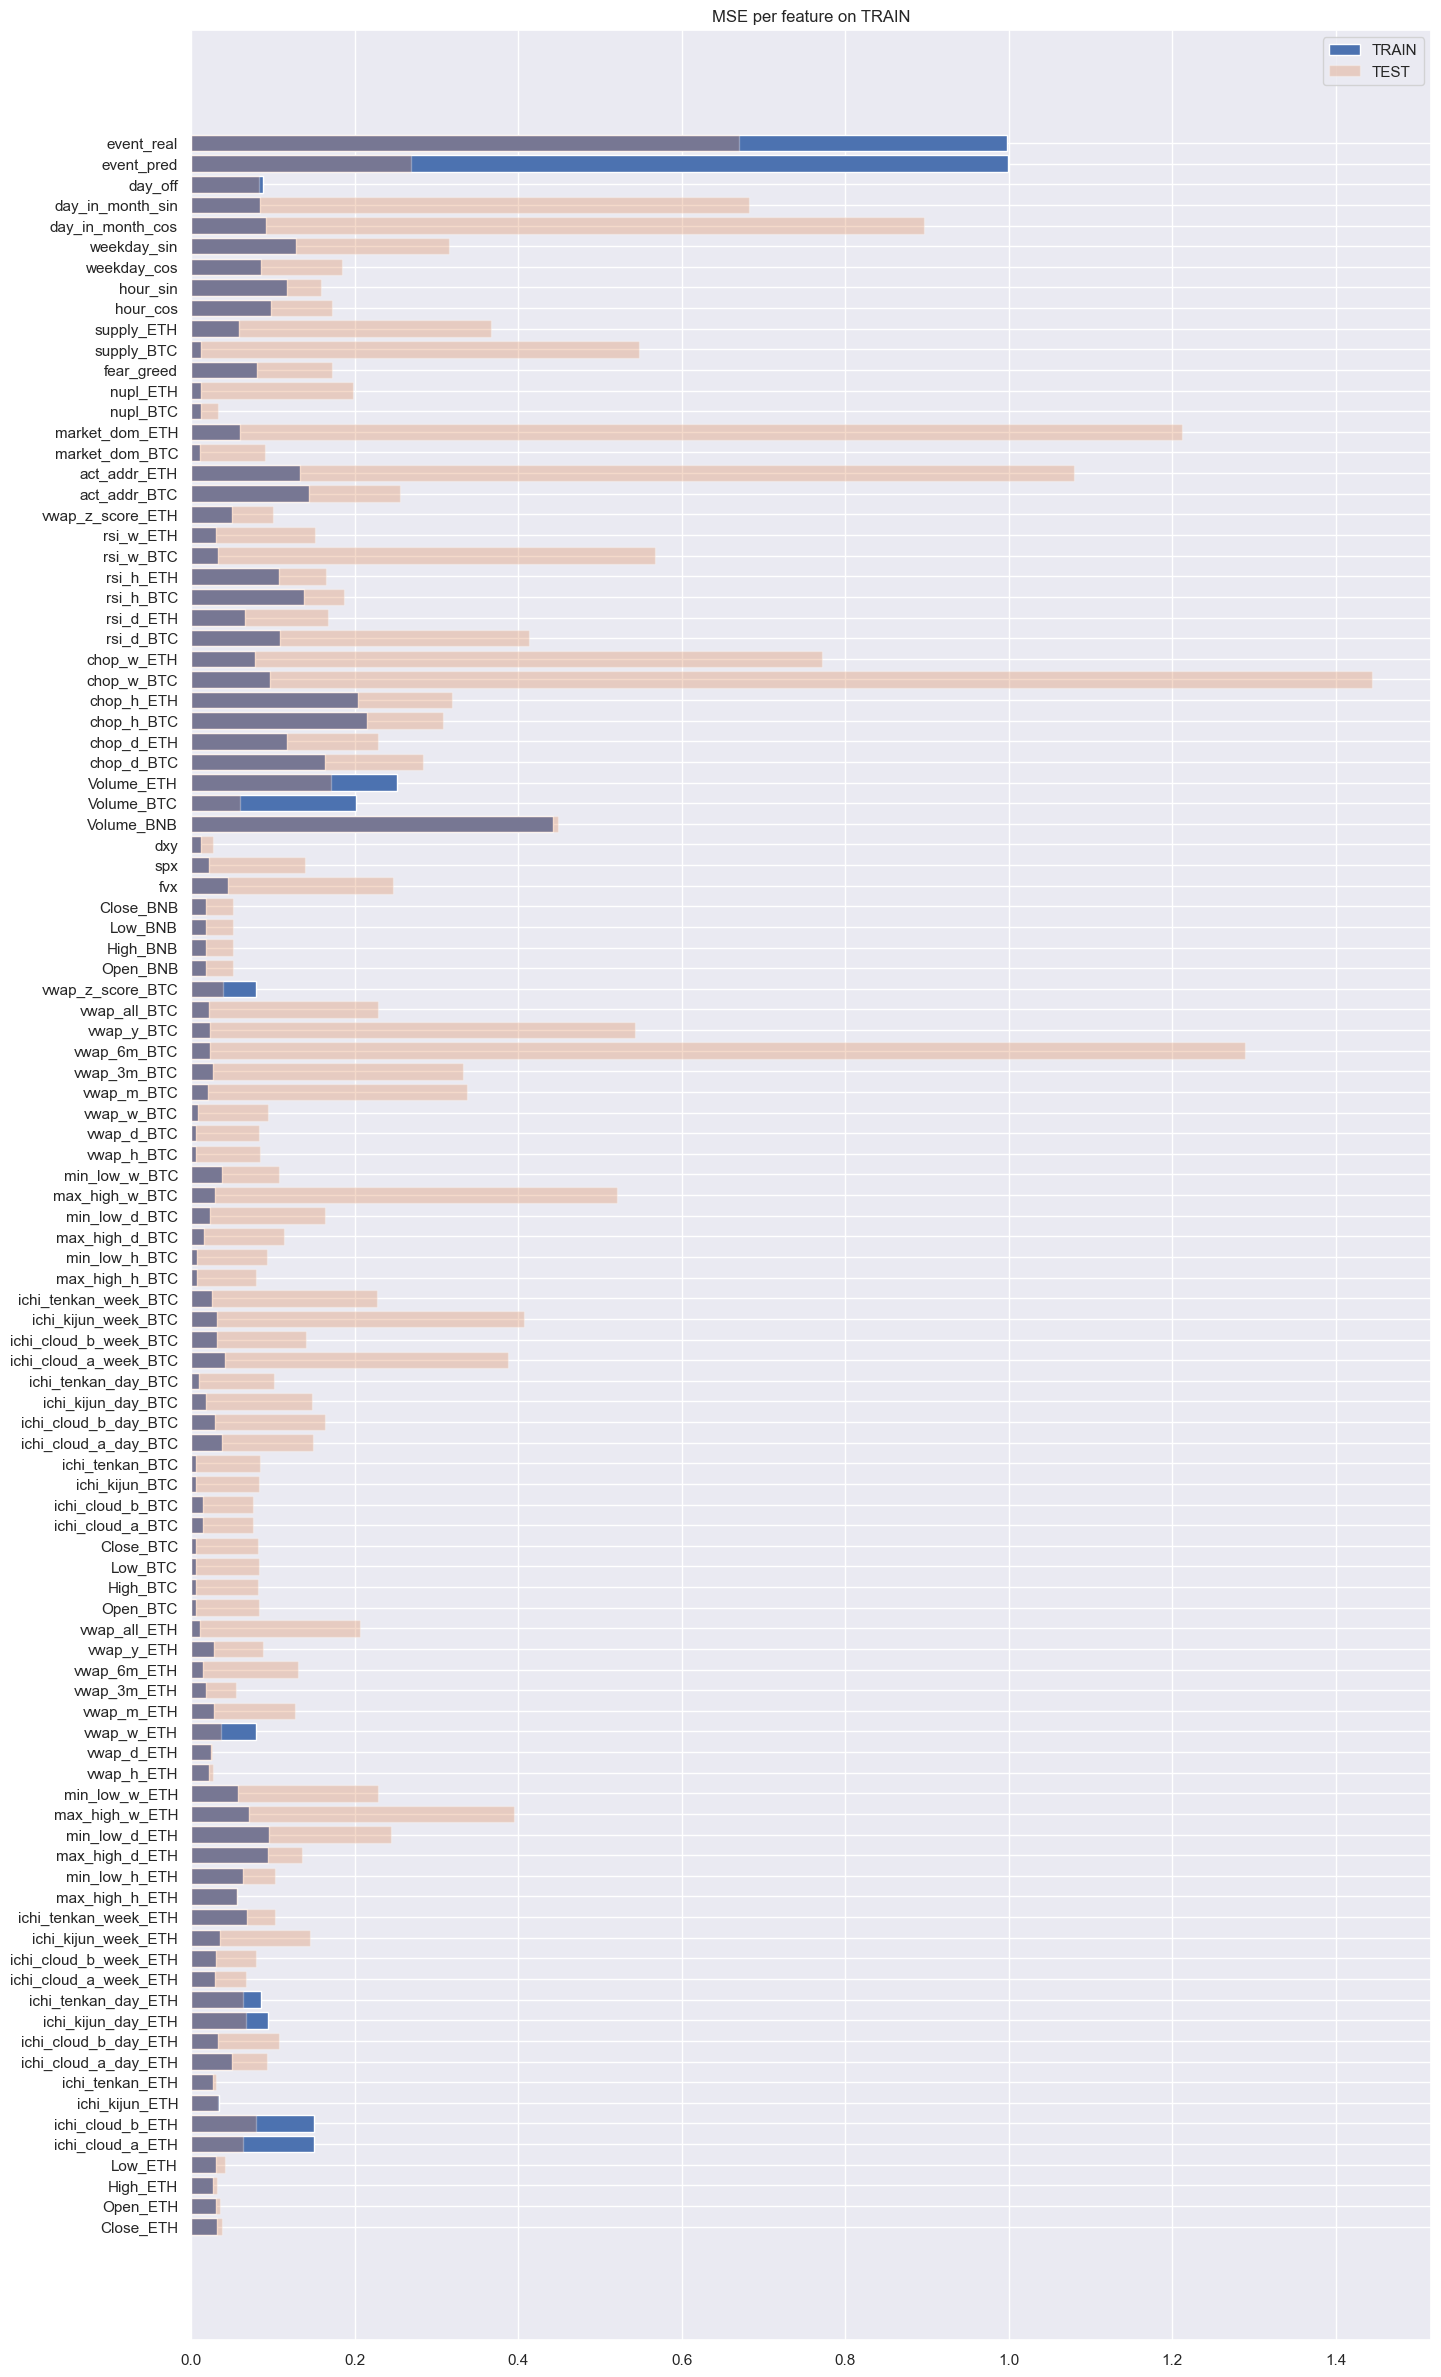

In [125]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [126]:
encoder_model.layers[3].get_weights()

[array([[ 0.14116363, -0.19734795, -0.24278711, ..., -0.39727816,
          0.03501137,  0.29975566],
        [ 0.18143563,  0.13581783, -0.01228285, ..., -0.09420189,
          0.08394898,  0.32804742],
        [-0.37808147, -0.3235442 , -0.66489416, ...,  0.12037014,
          0.1176393 , -0.18652262],
        ...,
        [ 0.11983374,  0.00115078,  0.18035324, ..., -0.105708  ,
          0.15870798,  0.06643255],
        [-0.22089045, -0.25091884, -0.0413993 , ..., -0.09903886,
         -0.015185  ,  0.19446474],
        [ 0.118075  , -0.14177556, -0.14994007, ...,  0.03571952,
          0.41411114, -0.13124706]], dtype=float32),
 array([ 0.19733065,  0.5540947 , -0.08667319, -0.21798289,  0.21177725,
         0.25264826,  0.5869911 , -0.083191  ,  0.47103897, -0.0919494 ,
        -0.02404505, -0.6576381 ,  0.11435606, -0.2238712 ,  0.24525495,
         0.31396285], dtype=float32)]

## Prediction Models

### LSTM all features

In [127]:
X_train_sca.shape

(57272, 72, 102)

In [128]:
X_train_sca.shape[-1]

102

In [129]:
X_train_sca.shape[-2:]

(72, 102)

In [130]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [131]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [132]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1790/1790 [==============================] - 20s 11ms/step


(57272, 72, 16)

In [133]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

446/446 [==============================] - 5s 11ms/step


(14251, 72, 16)

In [134]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [135]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [136]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [137]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((57272, 72, 20), (14251, 72, 20))

#### Correlations

In [138]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



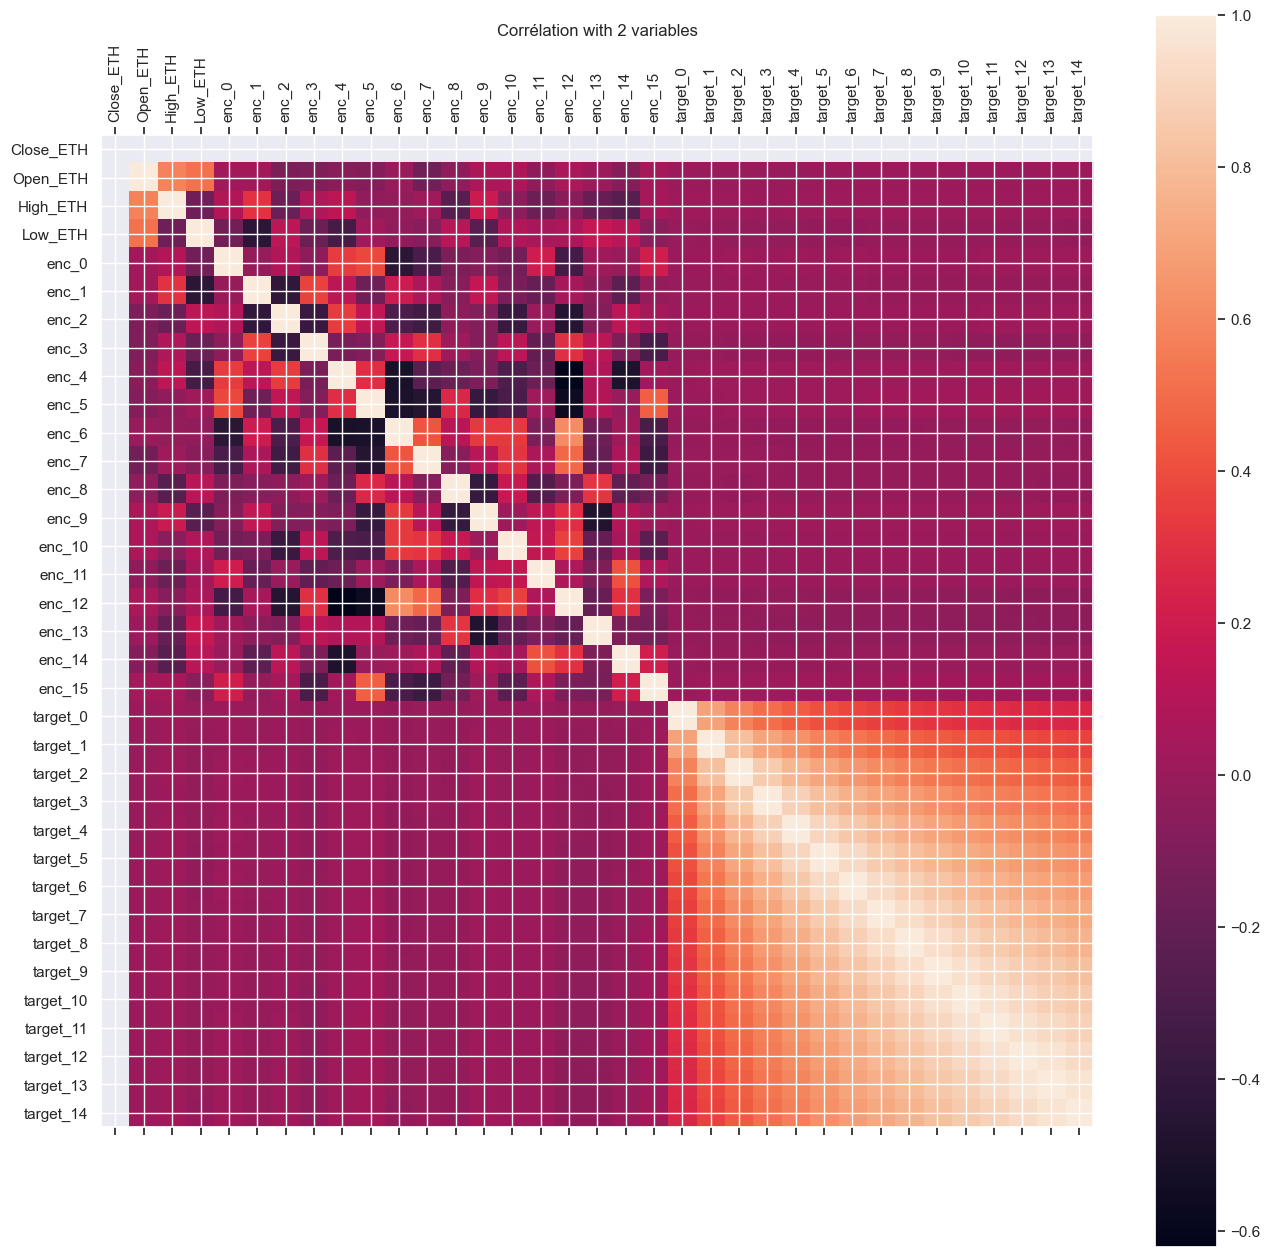

In [139]:
fig = plot_corr(corr_matrix_min)

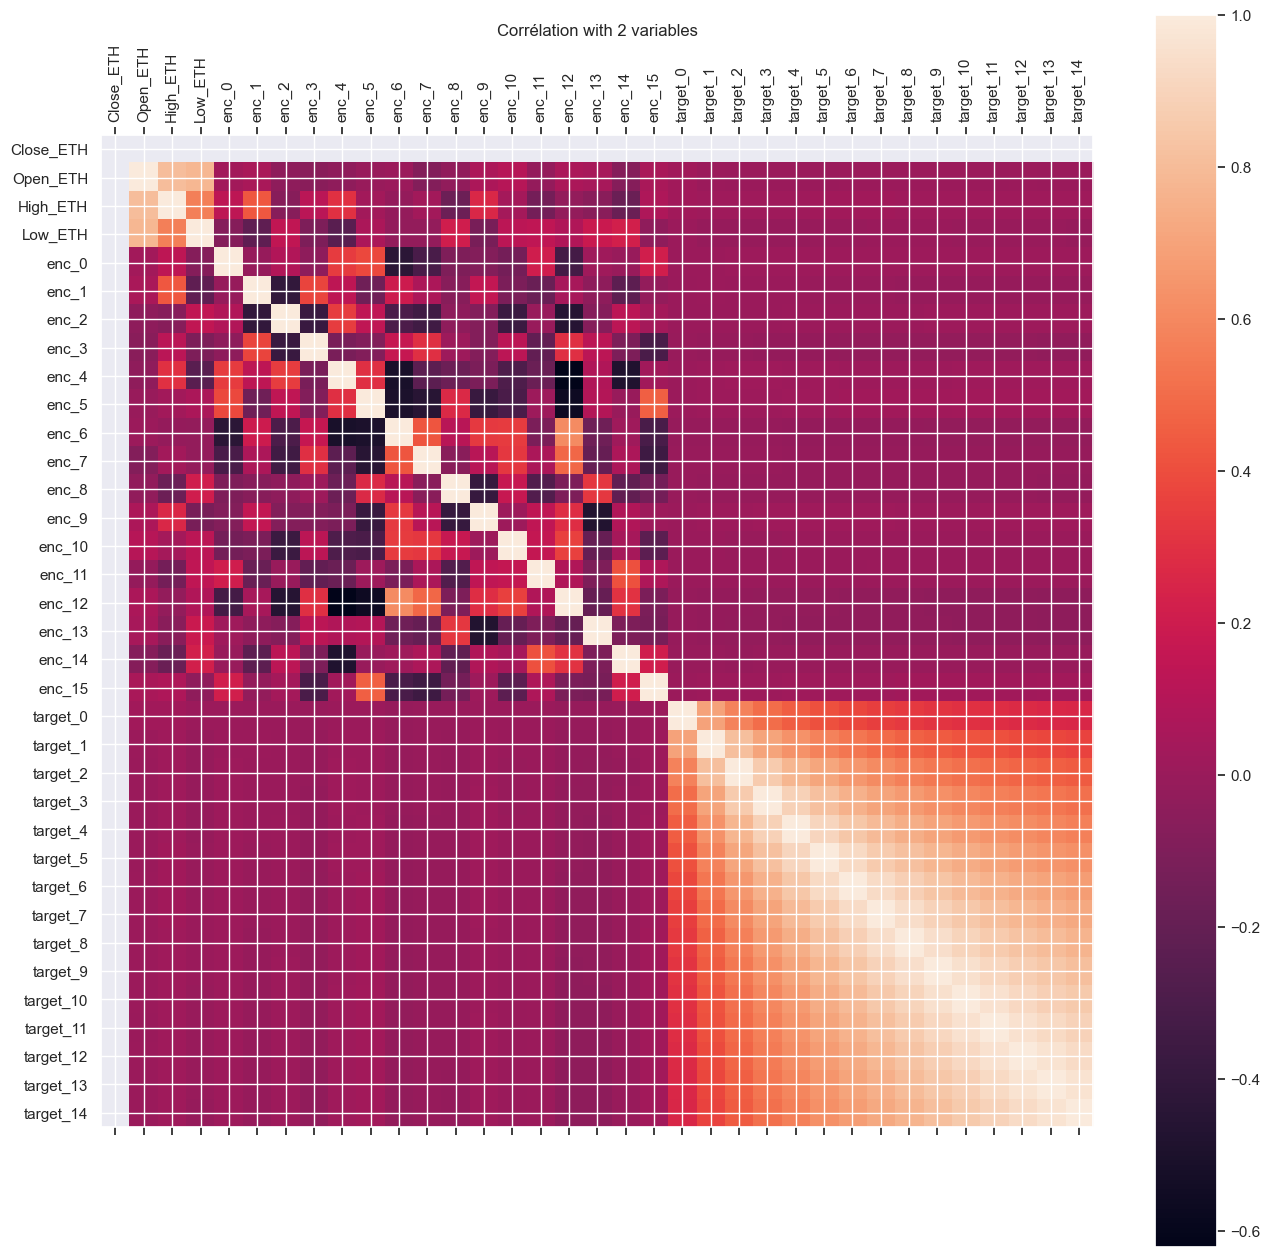

In [140]:
fig = plot_corr(corr_matrix_max) 

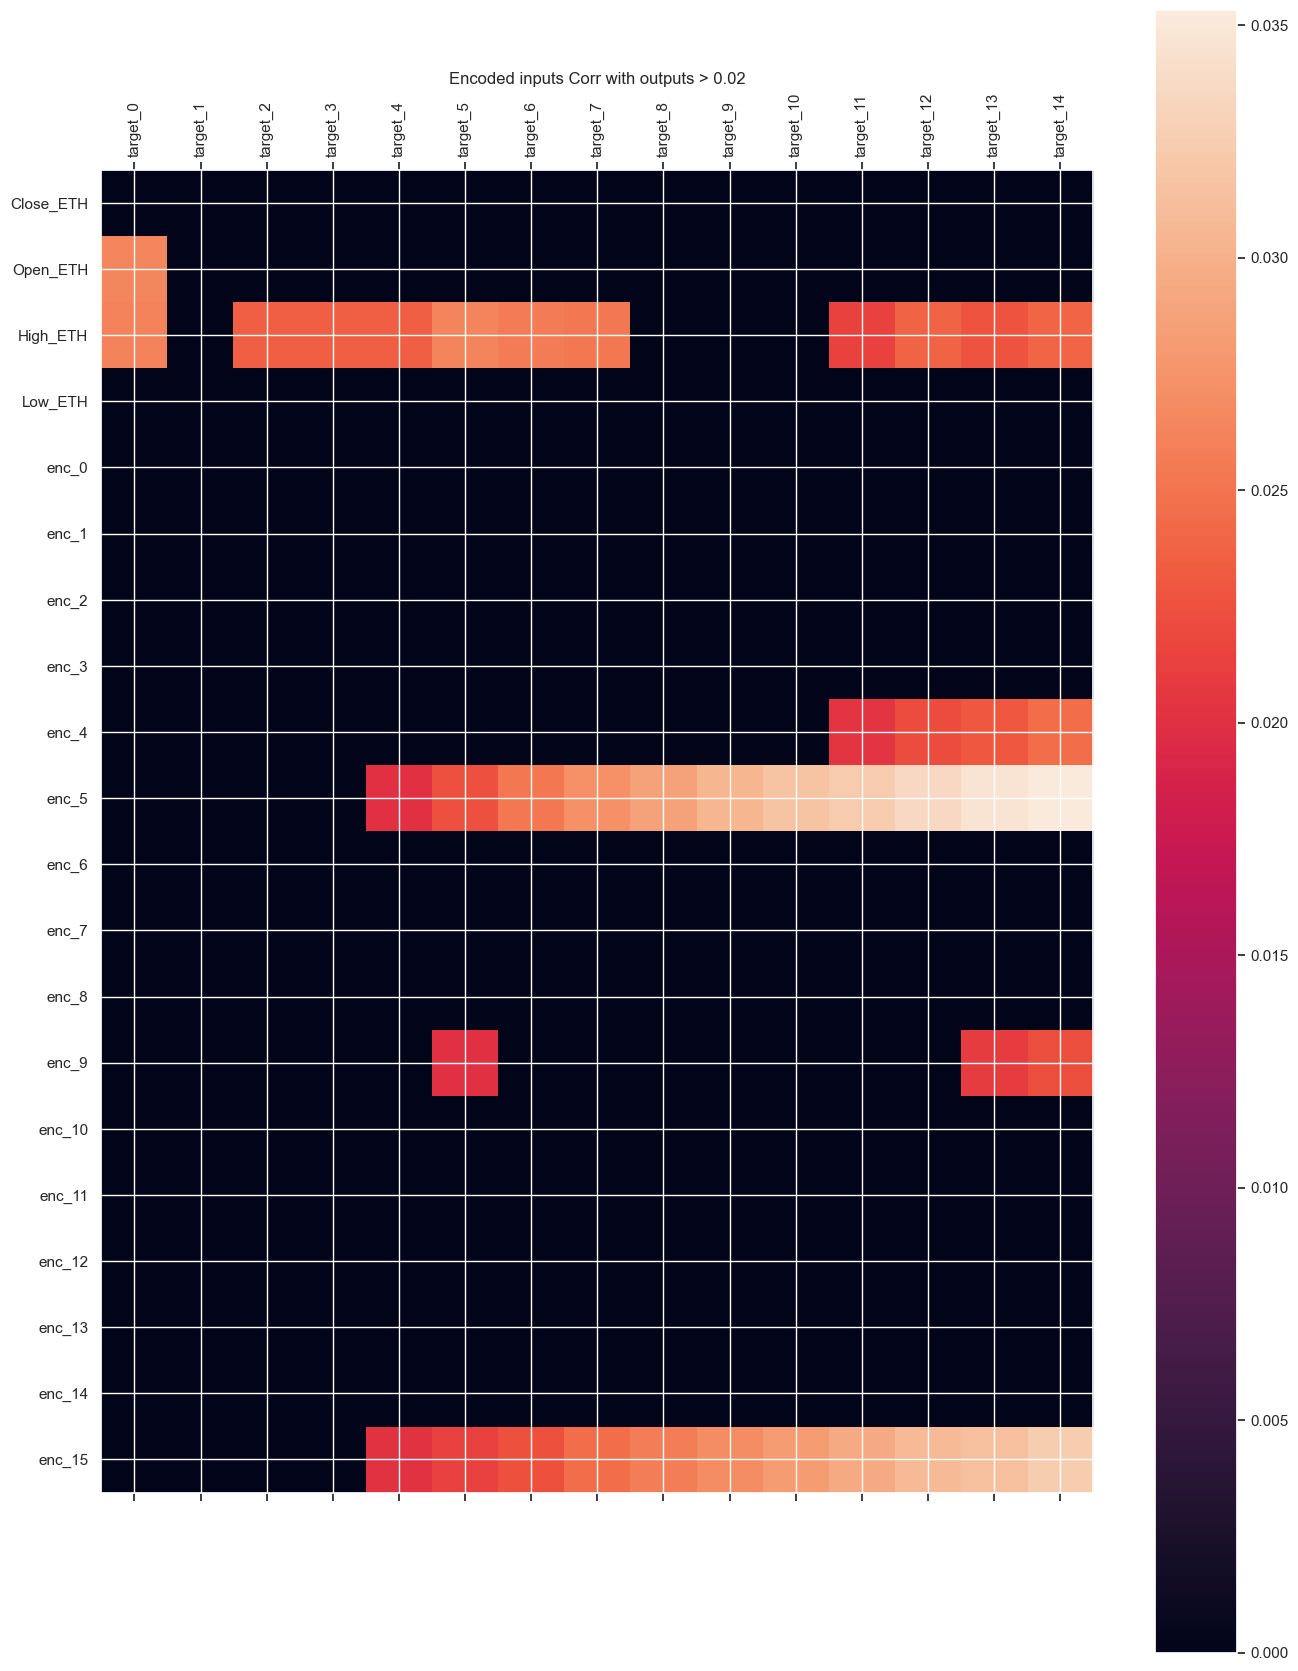

In [141]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

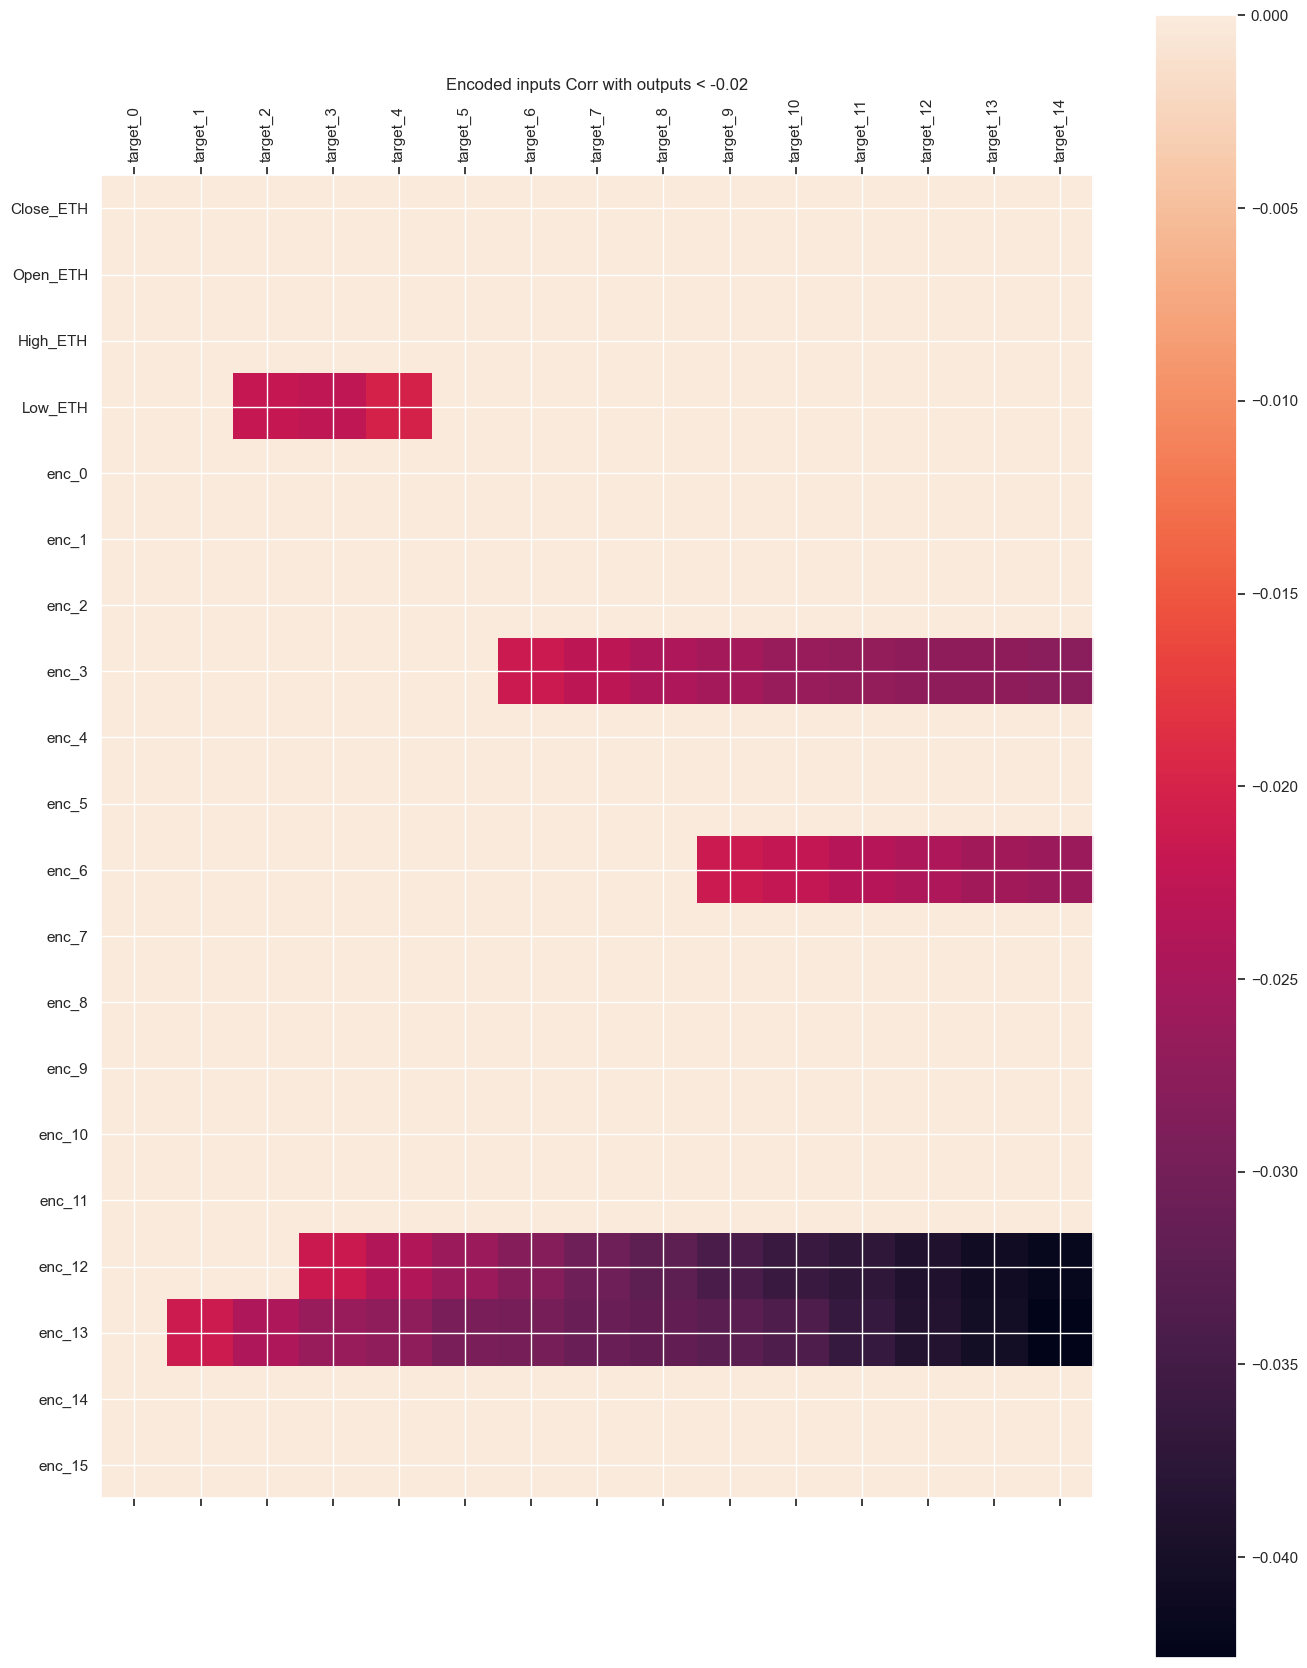

In [142]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [143]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [144]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [145]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [146]:
MODE_AUTO_SELECT

2

In [147]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[3, 4, 5, 6, 9, 12, 13, 15]
nb encoded features:  8


In [148]:
X_train_.shape

(57272, 72, 20)

In [149]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  7,  8,  9, 10, 13, 16, 17, 19])

In [150]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [151]:
X_train_.shape

(57272, 72, 12)

#### Train

In [152]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 20#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 74383 (290.56 KB)
Trainable params: 74383 (290.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [153]:
 print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [154]:
np.min(y_train)

0.925613296000411

In [155]:
np.max(y_train)

1.0749270774292548

#### Results

##### Save mdl

In [156]:
X_train_.shape

(57272, 72, 12)

##### Predict

In [157]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

446/446 [==============================] - 5s 11ms/step


##### Plots

In [158]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(57285,)
(57285,)


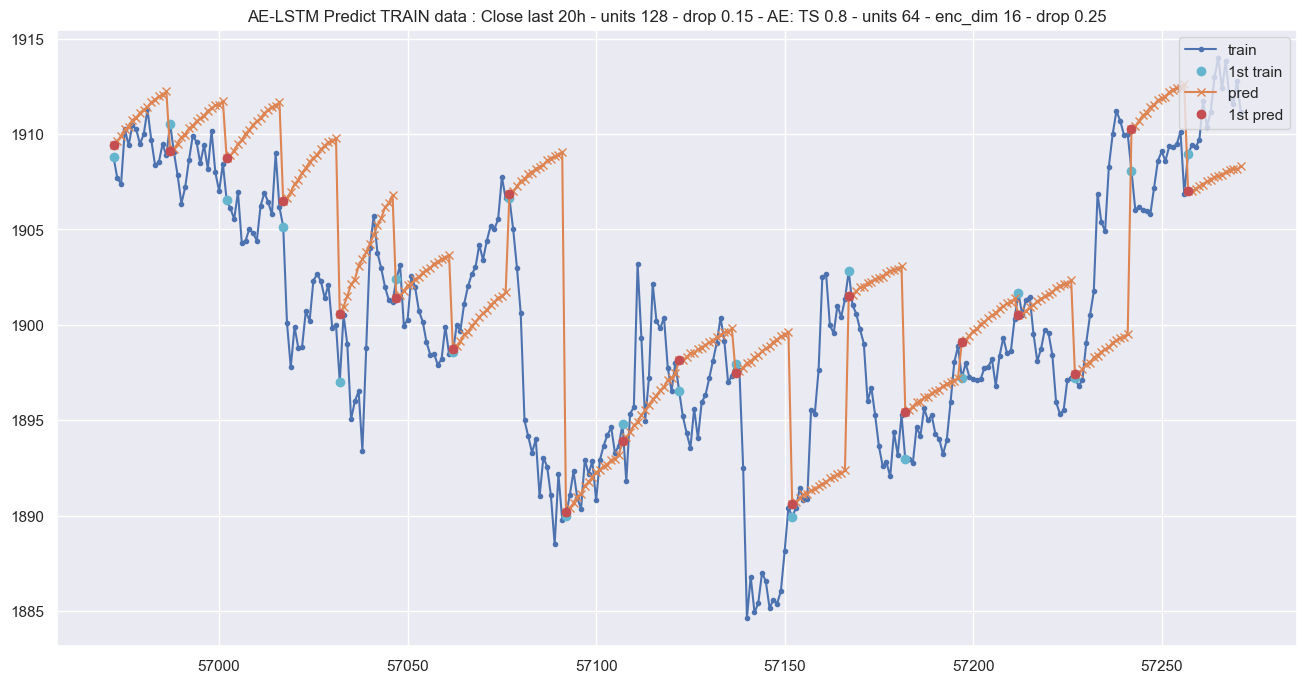

In [159]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

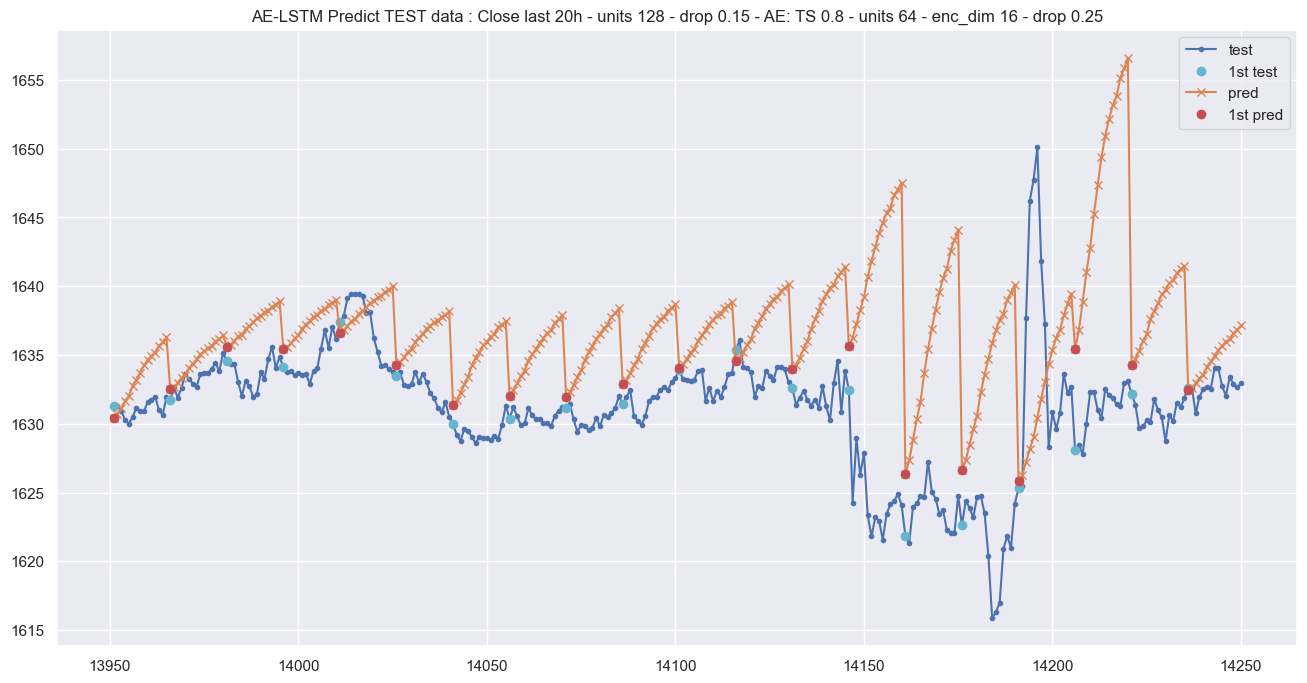

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

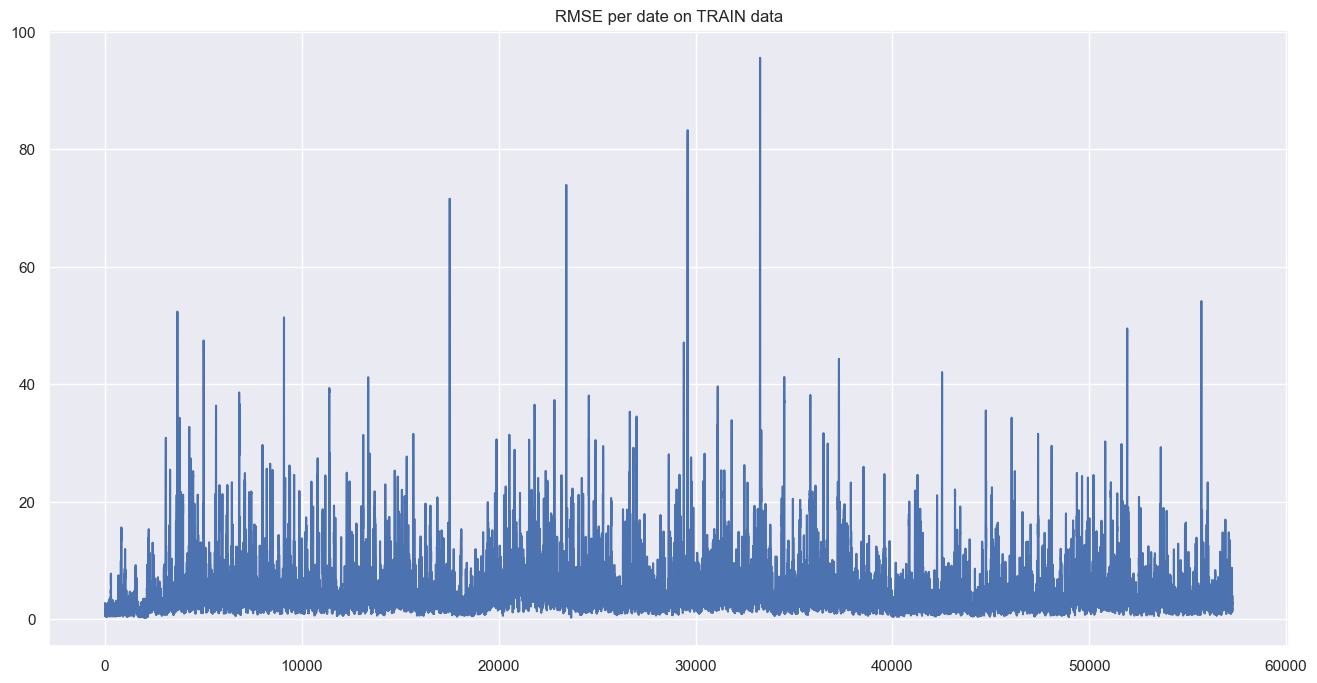

In [161]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

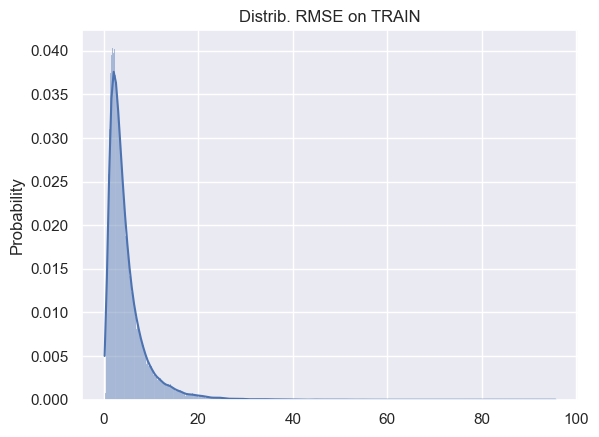

In [162]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.84')

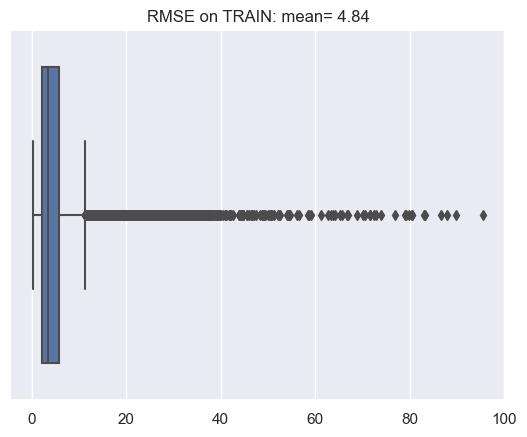

In [163]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

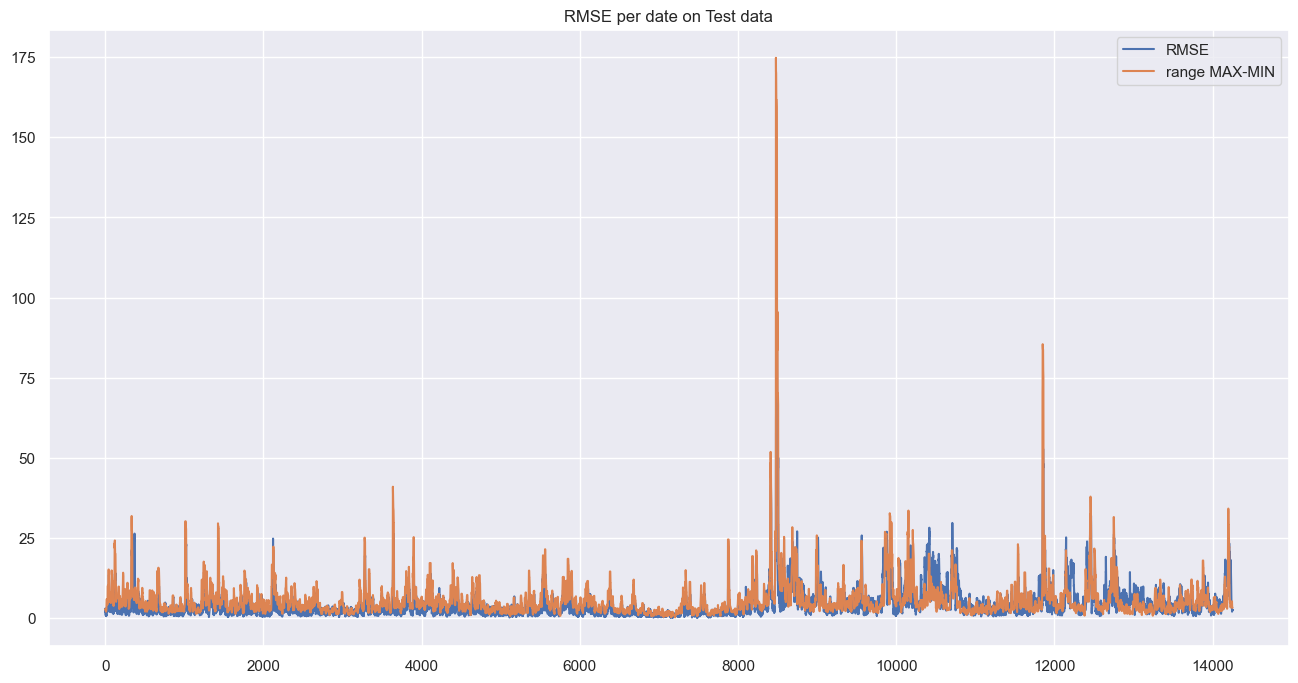

In [164]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [165]:
np.mean(arr_range)

6.066648656234652

<AxesSubplot: ylabel='Probability'>

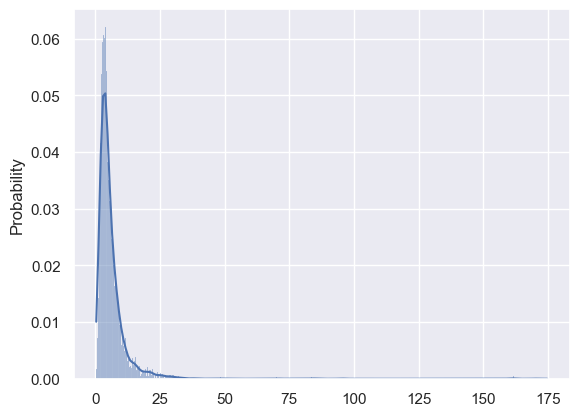

In [166]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [167]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.388083490763136

<AxesSubplot: ylabel='Probability'>

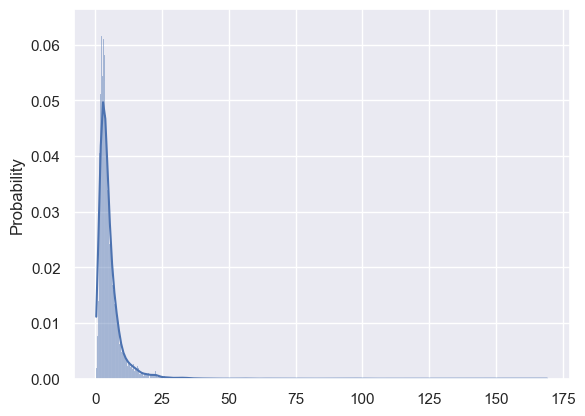

In [168]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

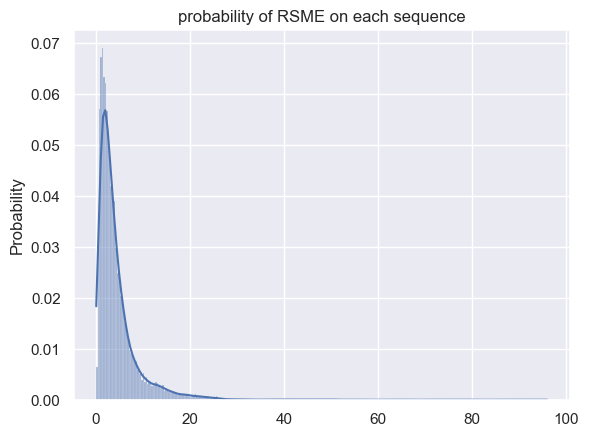

In [169]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 30.33324328117326)

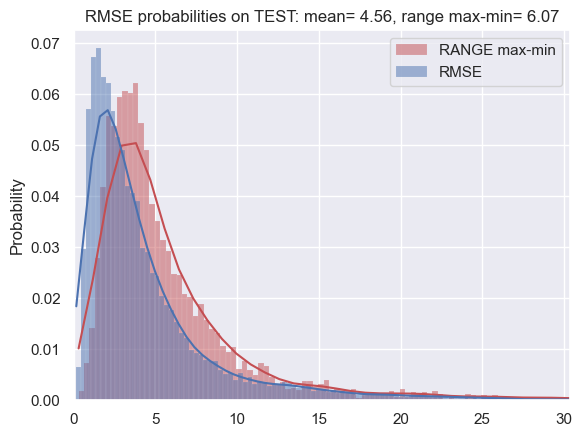

In [170]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 22.780776220234102)

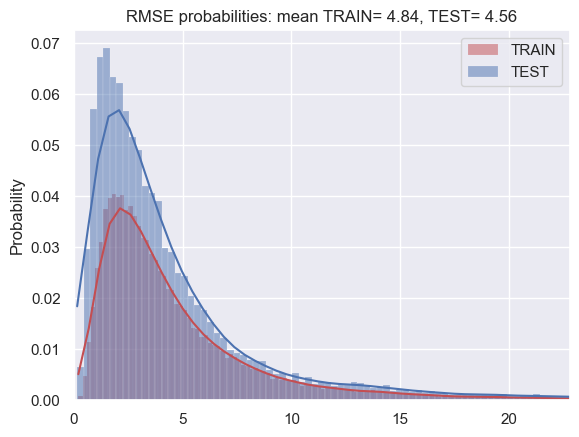

In [171]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 4.56')

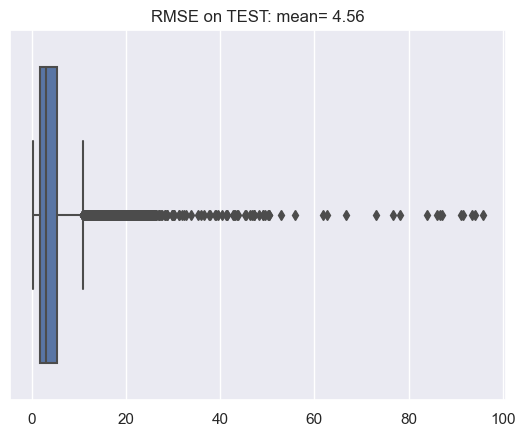

In [172]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [173]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1631.19 1631.86 1632.61 1632.6  1630.75 1631.97 1632.51 1632.66 1632.56
 1634.03 1634.03 1632.72 1632.05 1633.37 1632.91]
[1632.16054803 1632.38849445 1632.77903746 1633.20031045 1633.49632961
 1634.18892108 1634.6304214  1635.06297501 1635.55212625 1635.85884255
 1636.22974171 1636.41917841 1636.87332081 1637.15844833 1637.48208557]


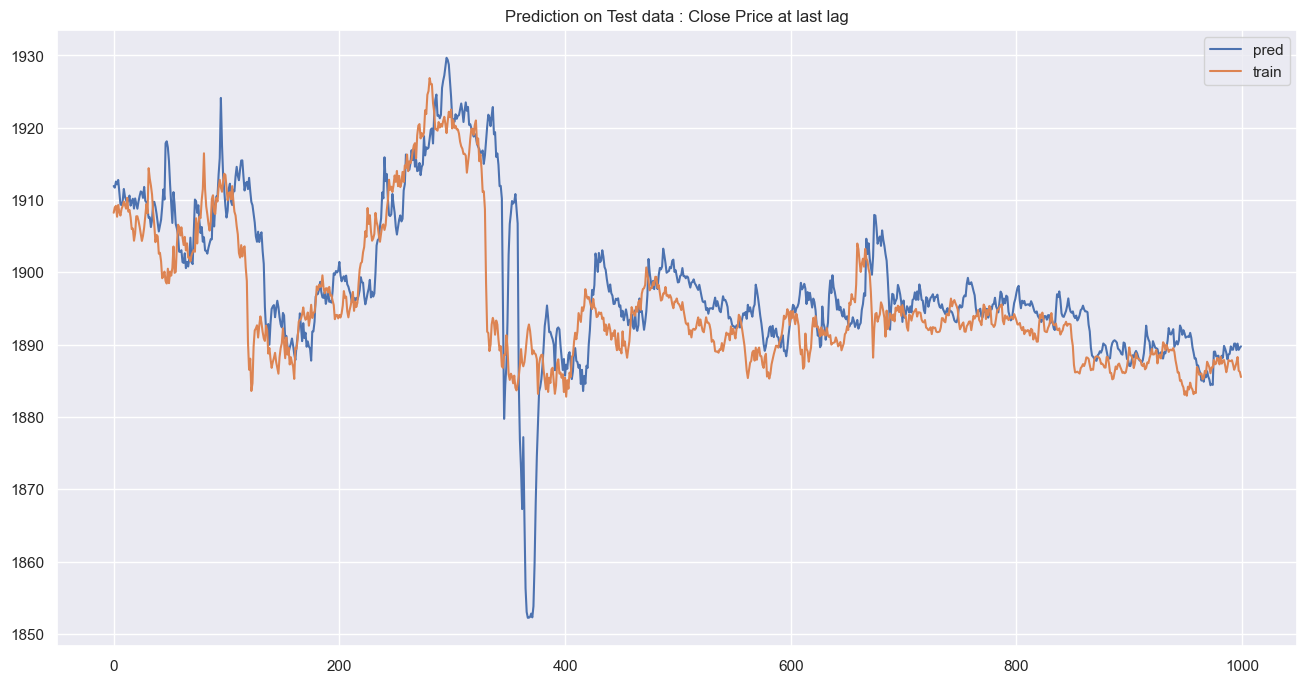

In [174]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

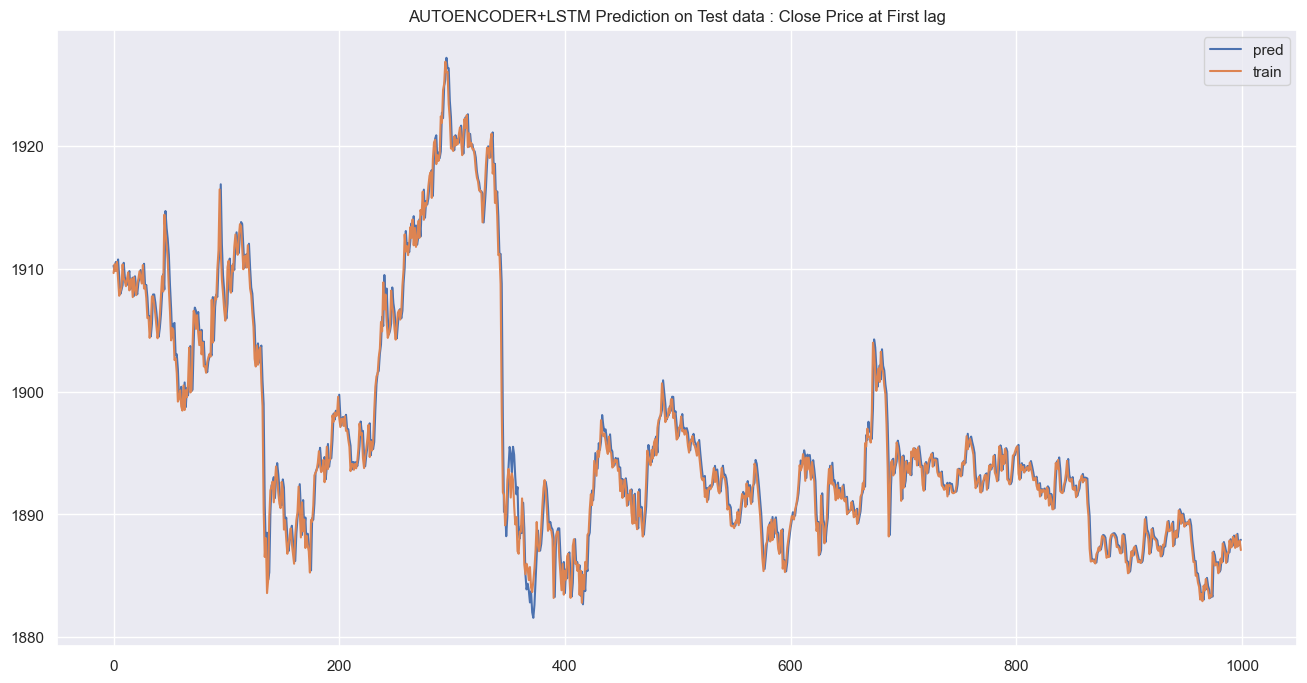

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

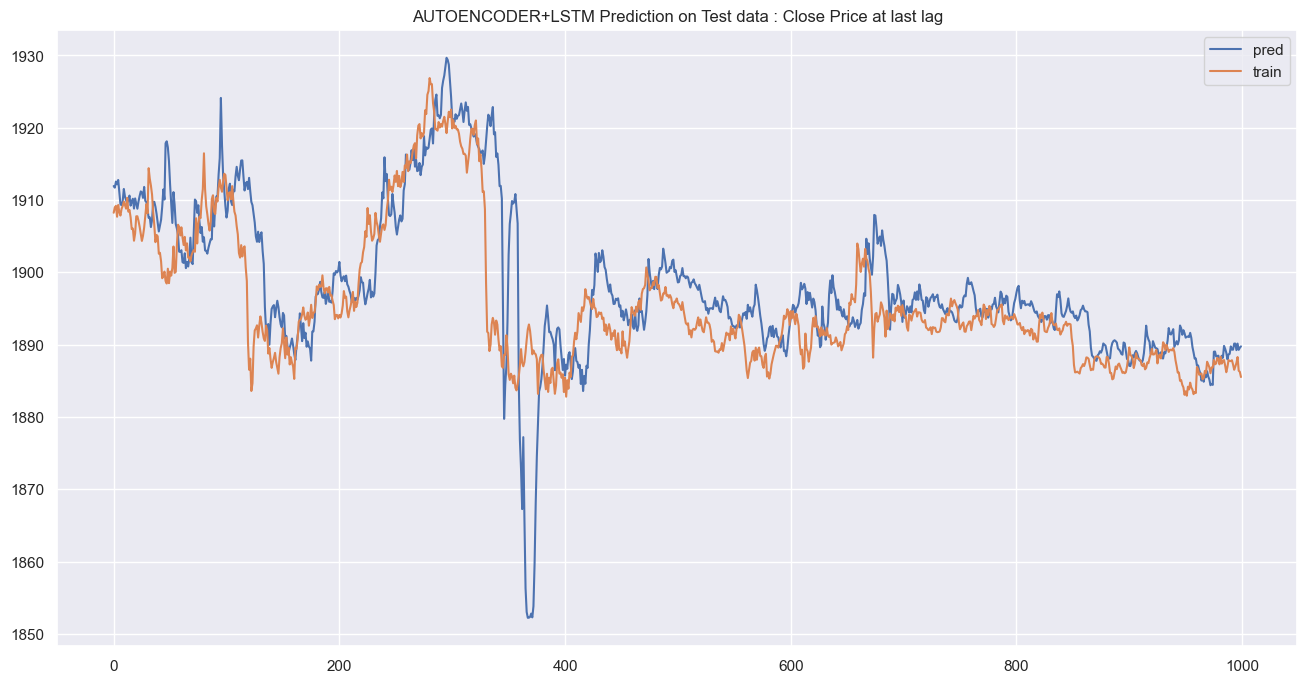

In [176]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [177]:
X_test_sca.shape

(14251, 72, 102)

In [178]:
df_feat["Close_ETH"].iloc[-1]

1633.29

In [179]:
df_feat["Close_ETH"].iloc[-1]

1633.29

In [180]:
len(list_i_enc_select)

8

In [181]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1624.66 1624.77 1623.49 1620.42 1615.89 1616.29 1617.   1620.89 1621.85
 1620.96 1624.16 1625.33 1625.49 1637.68 1646.23 1647.75 1650.1  1641.86
 1637.22 1628.29 1630.83 1629.61 1630.77 1633.62 1632.23 1632.69 1628.09
 1628.44 1627.79 1629.99 1632.31 1632.32 1631.   1630.43 1632.5  1632.07
 1631.85 1631.45 1631.26 1632.94 1633.11 1632.16 1631.37 1629.66 1629.8
 1630.25 1630.12 1631.81 1630.98 1630.47 1628.72 1630.65 1630.17 1631.53
 1631.19 1631.86 1632.61 1632.6  1630.75 1631.97 1632.51 1632.66 1632.56
 1634.03 1634.03 1632.72 1632.05 1633.37 1632.91 1632.65 1632.94 1633.29]
X_last[0,:,0] after divide by price:
[0.99471619 0.99478354 0.99399984 0.9921202  0.98934666 0.98959156
 0.99002627 0.99240796 0.99299573 0.99245082 0.99441006 0.9951264
 0.99522436 1.00268783 1.00792266 1.0088533  1.01029211 1.00524708
 1.00240619 0.99693869 0.99849384 0.99774688 0.9984571  1.00020205
 0.999351   0.99963264 0.99681624 0.99703053 0.99663256 0.99797954
 0.999

X_last_encoded[0,:,0]:
[ 0.2439086   0.19367298  0.05722944 -0.00307839  0.6585769  -0.35159326
 -0.2560897  -0.2563397  -0.28105485 -0.29659534 -0.29596815 -0.3192318
 -0.3125186   0.23050675  1.1035064  -0.9634245  -0.49370193 -0.39737952
 -0.41817015 -0.11389577 -0.34651148 -0.3182289  -0.30812776 -0.31176817
 -0.34644037 -0.316652   -0.302687   -0.30429935 -0.30202127 -0.30385536
 -0.31465352 -0.2728791  -0.21795362 -0.21161783 -0.22512612 -0.2329978
 -0.22651958 -0.23376837 -0.21557024 -0.27183837 -0.2956064  -0.3080681
 -0.30280203 -0.19661039 -0.23922575 -0.22748932 -0.25984707 -0.25665125
 -0.26808318 -0.23817378 -0.26174784 -0.30725116 -0.3172816  -0.34484416
 -0.34629542 -0.36993462 -0.3814873  -0.3947909  -0.3549897  -0.39116138
 -0.35931957 -0.37091428 -0.38335872 -0.45677882 -0.47630322 -0.45812428
 -0.38046205 -0.36952698 -0.38537598 -0.35832316 -0.35486954 -0.36984855]
(1, 72, 16)
X_last_encoded_sca[0,:,0]:
[ 0.42059115  0.33068973  0.08651097 -0.02141565  1.1626797  -0.

In [182]:
X_last_encoded_sca.shape

(1, 72, 16)

In [183]:
list_i_enc_select

[3, 4, 5, 6, 9, 12, 13, 15]

In [184]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 8)

In [185]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [186]:
X_train_.shape

(57272, 72, 12)

In [187]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
71692  1694038800000   1632.06   1633.38  1632.05    1633.37    128.2817   
71693  1694039100000   1633.37   1633.70  1632.90    1632.91    273.8451   
71694  1694039400000   1632.91   1633.12  1632.64    1632.65    130.8252   
71695  1694039700000   1632.65   1633.12  1632.29    1632.94    272.5678   
71696  1694040000000   1632.94   1633.30  1632.93    1633.29    155.3787   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1746.178516       1745.691288   
1      2023-01-01 00:05:00       1746.178516       1745.691288   
2      2023-01-01 00:10:00       1746.178516       1745.691288   
3      2023-01-01 00:15:00       1746.178516       1745.691288   
4      2023-01-01 00:20:00       1746.178516       1745.691288   
...                    ...               ...               ...   
71692  2023-09-06 22:20:00       1635.182500       1639.600000   
71693  2023-09-06 22:25:00       1634.597500       1639.600000   
71694  2023-09-06 22:30:00       1632.357500       1639.600000   
71695  2023-09-06 22:35:00       1631.175000       1639.600000   
71696  2023-09-06 22:40:00       1631.055000       1639.600000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
71692        1631.325  ...         NaN            NaN           NaN   
71693        1631.325  ...         NaN            NaN           NaN   
71694        1631.325  ...         NaN            NaN           NaN   
71695        1631.325  ...         NaN            NaN           NaN   
71696        1631.325  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
71692               NaN         0.0               NaN         0.0      0.0   
71693               NaN         0.0               NaN         0.0      0.0   
71694               NaN         0.0               NaN         0.0      0.0   
71695               NaN         0.0               NaN         0.0      0.0   
71696               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
71692                  NaN  False  
71693                  NaN  False  
71694                  NaN  False  
71695                  NaN  False  
71696                  NaN  False  

[71697 rows x 136 columns]

In [188]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [189]:
y_last_pred_unscaled

array([[1.0000774, 1.0001036, 1.0001954, 1.0003098, 1.0003597, 1.0005563,
        1.000684 , 1.0007777, 1.0009273, 1.0009984, 1.0011358, 1.001197 ,
        1.0013359, 1.0014474, 1.0015777]], dtype=float32)

In [190]:
df_feat["Close_ETH"].iloc[-1]

1633.29

In [191]:
y_last_pred_raw

array([[1633.4164, 1633.4592, 1633.6091, 1633.796 , 1633.8774, 1634.1987,
        1634.4072, 1634.5603, 1634.8047, 1634.9207, 1635.1451, 1635.245 ,
        1635.4719, 1635.6542, 1635.867 ]], dtype=float32)

In [192]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [193]:
list_pred

[1633.796,
 1633.8774,
 1634.1987,
 1634.4072,
 1634.5603,
 1634.8047,
 1634.9207,
 1635.1451,
 1635.245,
 1635.4719,
 1635.6542,
 1635.867]

In [194]:
save_list(list_pred, path_save_pred_vals)

In [195]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[1633.796,
 1633.8774,
 1634.1987,
 1634.4072,
 1634.5603,
 1634.8047,
 1634.9207,
 1635.1451,
 1635.245,
 1635.4719,
 1635.6542,
 1635.867]